# 데이터 불러오기

In [ ]:
# install code for Colab
# For MinMaxScaler
!pip install "dask[complete]"
!python -m pip install dask[dataframe] --upgrade
!pip install dask_ml

In [ ]:
!pip install dask-ml
!python -m pip install 'fsspec>=0.3.3'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/deep_learning_project/df_with_type.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)

# UDP데이터 전처리 

In [ ]:
# UDP
udp = df[df['Protocol']==17]

In [ ]:
value = pd.DataFrame(udp['Label'].value_counts())
value

,Label
Benign,1632095
Infilteration,51360
DDOS attack-LOIC-UDP,1730
Brute Force -Web,128
Brute Force -XSS,5


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


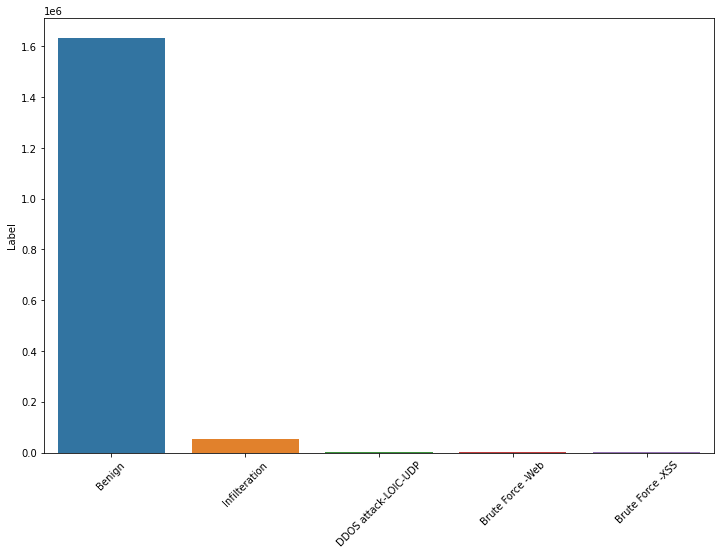

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,8))
sns.barplot(value.index,value['Label'])
plt.xticks(rotation=45)
plt.show()

In [ ]:
# normal vs abnormal = 30 : 1
udp['Type'].value_counts()

0    1632095
1      53223
Name: Type, dtype: int64

In [ ]:
from dask_ml.preprocessing import MinMaxScaler, LabelEncoder

X = udp.drop(columns=['Dst Port', 'Label', 'Type', 'Protocol'])
y = udp['Type']
y_ml = udp['Label']

# scale
mm = MinMaxScaler()
X_mm = mm.fit_transform(X)

In [ ]:
udp_scale = pd.concat([X_mm,y,y_ml],axis=1)

normal_udp = udp_scale[udp_scale['Type']==0]
abnormal_udp = udp_scale[udp_scale['Type']==1]

# 학습 : 정상 135만개 
# 테스트 : 정상 33만개, 비정상 5.3만개 
normal_X = normal_udp.drop(columns=['Type','Label'])
normal_y = normal_udp['Type']

from dask_ml.model_selection import train_test_split
normal_train_X ,normal_test_X, normal_train_y, normal_test_y = train_test_split(normal_X, normal_y, test_size=0.2, random_state=13)


abnormal_X = abnormal_udp.drop(columns=['Type','Label'])
abnormal_y = abnormal_udp['Type']


test_X = pd.concat([normal_test_X,abnormal_X])
test_y = pd.concat([normal_test_y,abnormal_y])

In [ ]:
test_data_effort = pd.concat([test_X,test_y],axis=1)
test_data_effort = test_data_effort.sample(frac=1)

test_X = test_data_effort.drop('Type',axis=1)
test_y = test_data_effort['Type']

In [ ]:
len(normal_train_X),len(test_X),len(normal_train_y),len(test_y)

(1305676, 379642, 1305676, 379642)

In [ ]:
pd.options.display.float_format = '{:.6f}'.format

# DataLodaer에 넣기 

In [ ]:
from torch.utils.data import Dataset
import torch 

# reset_index
def get_new_idx(data):
  data = data.reset_index().drop('index',axis=1)
  return data

# customize dataset
class CustomDataset(Dataset):
  def __init__(self, feature, label):
    self.feature = feature
    self.label = label

  def __len__(self):
    return len(self.feature)

  def __getitem__(self, index) : 
    feature = torch.from_numpy(self.feature.loc[index].values).float()
    label = torch.from_numpy(self.label.loc[index].values).float()
    
    return feature, label

In [ ]:
normal_train_y.head()

5114628    0
4916256    0
5674874    0
4100336    0
4682381    0
Name: Type, dtype: int64

In [ ]:
from torch.utils.data import DataLoader

len(normal_train_X),len(test_X),len(normal_train_y),len(test_y)
normal_train_X = get_new_idx(normal_train_X)
normal_train_y = get_new_idx(normal_train_y)
tot_test_X = get_new_idx(test_X)
tot_test_y = get_new_idx(test_y)

# to_tensor and dataloader
BATCH_SIZE = 128
train_loader = DataLoader(CustomDataset(normal_train_X, normal_train_y), BATCH_SIZE, shuffle=True)
test_loader = DataLoader(CustomDataset(tot_test_X, tot_test_y), BATCH_SIZE, shuffle=True)


In [ ]:
import torch
for data in train_loader:
  BATCH_SIZE, FEATURE_NUM = data[0].shape
  break

print(BATCH_SIZE, FEATURE_NUM)

128 76


# Base AE Model - AutoEncoder
- code_size = 2

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# AutoEncoder
class AutoEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, code_size=2):
    super(AutoEncoder, self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim

    self.encoder = nn.Sequential(
        nn.Linear(input_dim, code_size),
        nn.BatchNorm1d(2),
        nn.ReLU(),
    )

    self.decoder = nn.Sequential(
        nn.Linear(code_size, output_dim),
        nn.Sigmoid()
    )

  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [ ]:
# Simple AE setting
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(input_dim=FEATURE_NUM, 
                    output_dim=FEATURE_NUM).to(DEVICE)
criterion = nn.MSELoss()
learning_rate = 0.0008
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=76, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=76, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
from tqdm import tqdm
from collections import defaultdict
train_losses = []

minimum = float('inf')
dic = defaultdict(int)

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
  running_loss = 0
  model.train()
  for datas in train_loader:
    data, _ = datas
    data = data.to(DEVICE)
    data = data.float()
    # ===================forward=====================
    encoded,decoded = model.forward(data)
    loss = criterion(decoded, data)

    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()

    # Step backwards
    optimizer.step()
    running_loss += loss.item()
  val = running_loss/len(train_loader)
  train_losses.append(val)

  # Early stopping
  if np.round(val,4) <= minimum : 
    minimum = np.round(val,4)
    dic[minimum] += 1
    if dic[minimum] > 3 : 
      break
  # ===================log========================
  print(f'epoch [{epoch + 1}/{num_epochs}], train loss:{val:.4f}')

 10%|█         | 1/10 [04:32<40:52, 272.54s/it]

epoch [1/10], train loss:0.0048


 20%|██        | 2/10 [09:01<36:05, 270.68s/it]

epoch [2/10], train loss:0.0004


 30%|███       | 3/10 [13:30<31:29, 269.86s/it]

epoch [3/10], train loss:0.0002


 40%|████      | 4/10 [17:59<26:55, 269.23s/it]

epoch [4/10], train loss:0.0002


 50%|█████     | 5/10 [22:27<22:23, 268.77s/it]

epoch [5/10], train loss:0.0001


 60%|██████    | 6/10 [26:54<17:52, 268.17s/it]

epoch [6/10], train loss:0.0001


 70%|███████   | 7/10 [31:21<13:23, 267.82s/it]

epoch [7/10], train loss:0.0001


 70%|███████   | 7/10 [35:47<15:20, 306.81s/it]


In [ ]:
torch.save(model,'/content/drive/MyDrive/AD-DL Proj/model/UDP_SimpleAE_code2_B128_E10_model_udp_total_data.pt')

In [ ]:
model = torch.load('/content/drive/MyDrive/AD-DL Proj/model/UDP_SimpleAE_code2_B128_E10_model_udp_total_data.pt')

In [ ]:
# code_size = 2
# train_loss collection
from tqdm import tqdm
model.eval()

train_loss_collection = []

with torch.no_grad():
  for datases in tqdm(train_loader): 
    datas, labels = datases
    for data, label in zip(datas, labels):
      data = data.to(DEVICE)
      label = np.array(label)
      data = data.reshape(1, data.shape[0])
      encoded, decoded = model.forward(data)
      loss = criterion(decoded, data)
      loss = loss.item()
      train_loss_collection.append(loss)

len(train_loss_collection)

100%|██████████| 10201/10201 [10:15<00:00, 16.58it/s]


1305676

In [ ]:
import numpy as np
np.set_printoptions(precision=6, suppress=True)
threshold = np.percentile(train_loss_collection, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
threshold

array([0.      , 0.000001, 0.000003, 0.000005, 0.000007, 0.000009,
       0.000011, 0.000013, 0.000017, 0.000033, 0.159236])

In [ ]:
# code_size = 2
# model
# threshold
from tqdm import tqdm
model.eval()

predicted_abnormal = []
predicted_normal = []
real_abnormal = []
real_normal = []
total_loss = []
zero = []
one = []

test_result = pd.DataFrame(columns=['tp', 'fp', 'tn', 'fn', 'acc', 'f1', 'precision', 'recall'], index=threshold)

for th in threshold:
  # evaluation initiation
  tp = fn = fp = tn = 0
  with torch.no_grad():
    for datases in tqdm(test_loader): 
      datas, labels = datases
      running_val_loss = 0 
      real_abnormal = []
      for data, label in zip(datas, labels):
        data = data.to(DEVICE)
        label = np.array(label)
        data = data.reshape(1, data.shape[0])
        encoded, decoded = model.forward(data)
        loss = criterion(decoded, data)
        loss = loss.item()
        # loss >= 0.001 ; predict as 'Abnormal'
        if loss >= th:
          # label == 0 ; real 'Normal'
          if label == 0: 
            fp += 1
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            tp += 1
            real_abnormal.append(loss)
          predicted_abnormal.append(loss)
        # loss < 0.001 ; predict as 'Normal'
        elif loss < th: 
          # label == 0 ; real 'Normal'
          if label == 0: 
            tn += 1
            real_normal.append(loss)
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            fn += 1
          predicted_normal.append(loss)
        total_loss.append(loss)
        if label == 1:
          one.append(loss)
        else:
          zero.append(loss)
  try : 
    acc = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    test_result.loc[th] = [tp, fp, tn, fn, acc, f1, precision, recall]
  except : 
    continue
test_result

100%|██████████| 2966/2966 [03:06<00:00, 15.88it/s]


,tp,fp,tn,fn,acc,f1,precision,recall
0.000000,53223,326419,0,0,0.140193,0.245910,0.140193,1.000000
0.000001,48379,294255,32164,4844,0.212155,0.244427,0.141197,0.908987
0.000003,43650,261335,65084,9573,0.286412,0.243713,0.143122,0.820134
0.000005,38356,228521,97898,14867,0.358901,0.239650,0.143722,0.720666
0.000007,32119,195844,130575,21104,0.428546,0.228454,0.140896,0.603480
0.000009,26856,163148,163271,26367,0.500806,0.220831,0.141344,0.504594
0.000011,21270,130421,195998,31953,0.572297,0.207599,0.140219,0.399639
0.000013,16100,97588,228831,37123,0.645163,0.192917,0.141616,0.302501
0.000017,11176,65303,261116,42047,0.717234,0.172334,0.146132,0.209984
0.000033,5431,32822,293597,47792,0.787658,0.118742,0.141976,0.102042


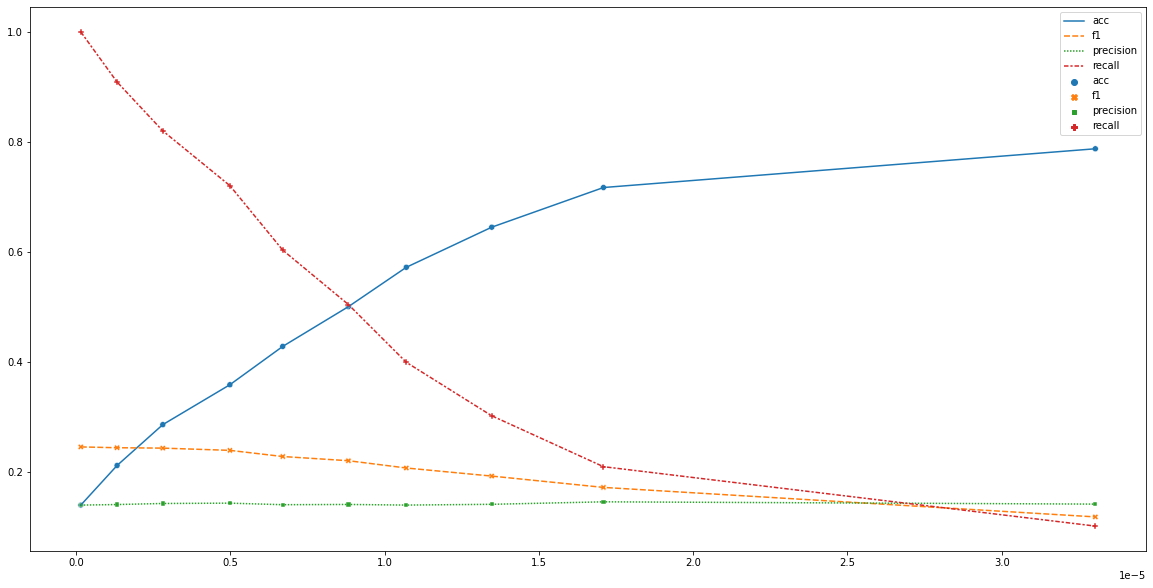

In [ ]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
sns.scatterplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
plt.show()

In [ ]:
import numpy as np
threshold = np.percentile(train_loss_collection, [10,13,15])
threshold

array([1.75465243e-06, 1.99975199e-06, 2.10485655e-06])

In [ ]:
# code_size = 2
# model
# threshold
from tqdm import tqdm
model.eval()

predicted_abnormal = []
predicted_normal = []
real_abnormal = []
real_normal = []
total_loss = []
zero = []
one = []

test_result = pd.DataFrame(columns=['tp', 'fp', 'tn', 'fn', 'acc', 'f1', 'precision', 'recall'], index=threshold)

for th in threshold:
  # evaluation initiation
  tp = fn = fp = tn = 0
  with torch.no_grad():
    for datases in tqdm(test_loader): 
      datas, labels = datases
      running_val_loss = 0 
      real_abnormal = []
      for data, label in zip(datas, labels):
        data = data.to(DEVICE)
        label = np.array(label)
        data = data.reshape(1, data.shape[0])
        encoded, decoded = model.forward(data)
        loss = criterion(decoded, data)
        loss = loss.item()
        # loss >= 0.001 ; predict as 'Abnormal'
        if loss >= th:
          # label == 0 ; real 'Normal'
          if label == 0: 
            fp += 1
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            tp += 1
            real_abnormal.append(loss)
          predicted_abnormal.append(loss)
        # loss < 0.001 ; predict as 'Normal'
        elif loss < th: 
          # label == 0 ; real 'Normal'
          if label == 0: 
            tn += 1
            real_normal.append(loss)
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            fn += 1
          predicted_normal.append(loss)
        total_loss.append(loss)
        if label == 1:
          one.append(loss)
        else:
          zero.append(loss)
  try : 
    acc = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    test_result.loc[th] = [tp, fp, tn, fn, acc, f1, precision, recall]
  except : 
    continue
test_result

100%|██████████| 2966/2966 [03:07<00:00, 15.79it/s]


,tp,fp,tn,fn,acc,f1,precision,recall
0.000002,48077,294057,32362,5146,0.211881,0.243208,0.140521,0.903312
0.000002,46648,284067,42352,6575,0.234431,0.242998,0.141052,0.876463
0.000002,45711,277610,48809,7512,0.248971,0.242792,0.14138,0.858858


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

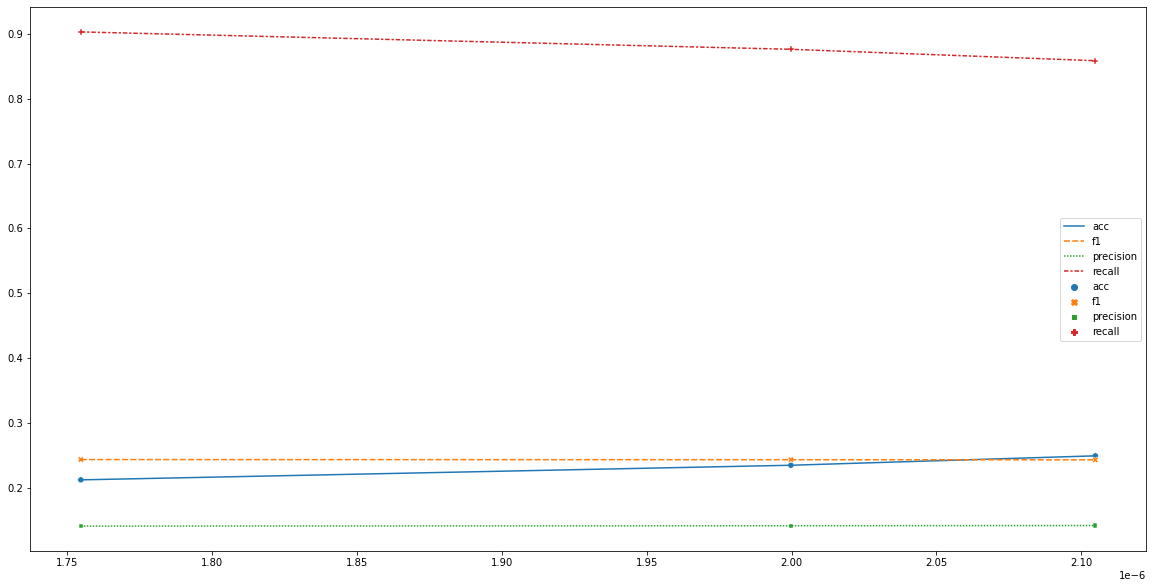

In [ ]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
sns.scatterplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


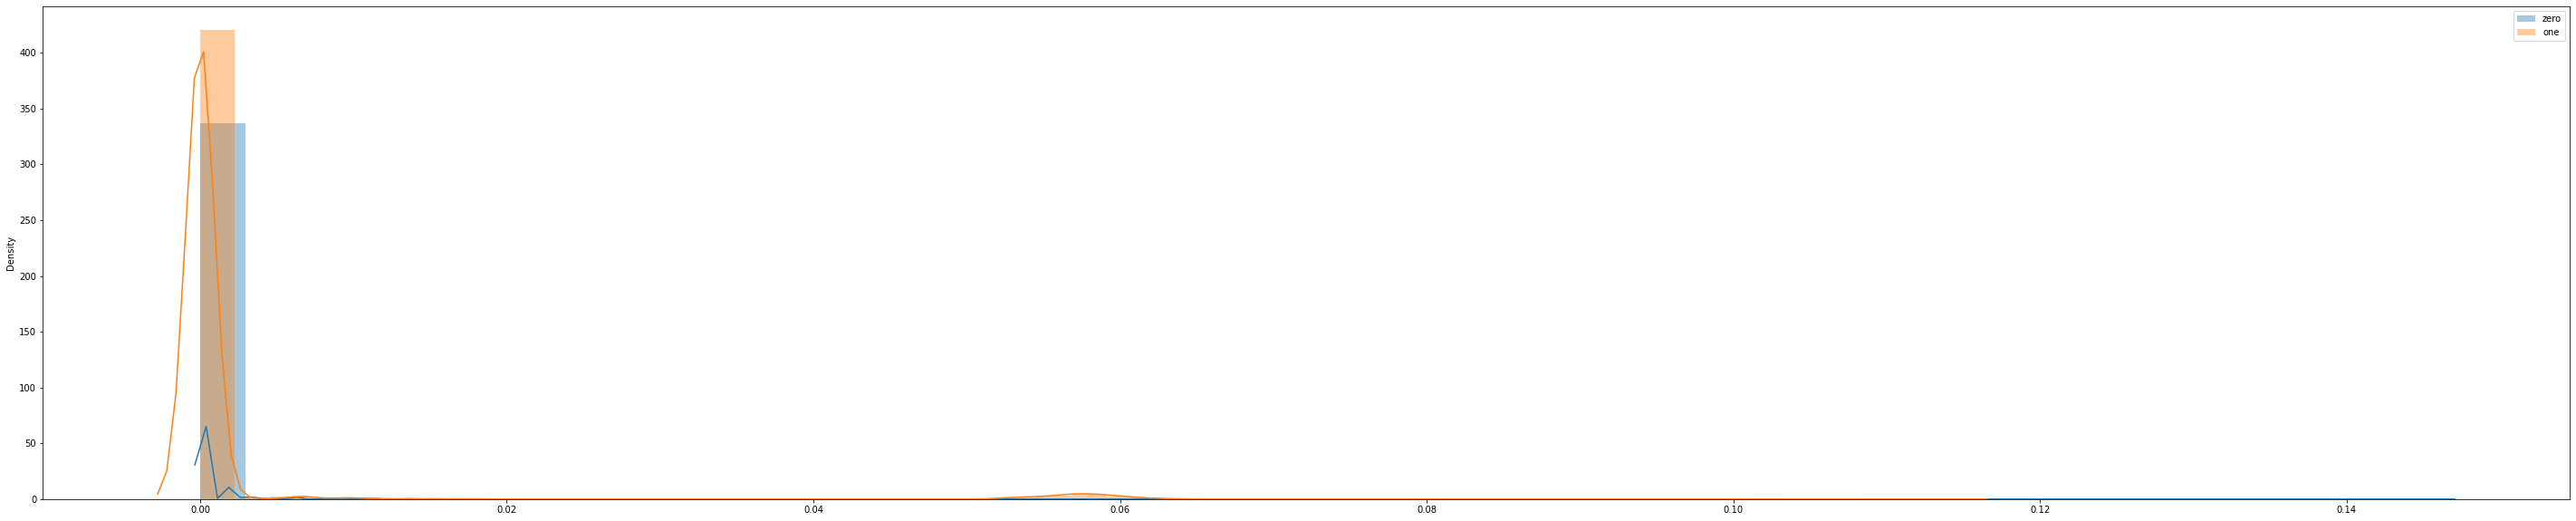

In [ ]:

plt.figure(figsize=(50, 10))
sns.distplot(zero, label='zero')
sns.distplot(one, label='one')
plt.legend()
plt.show()

In [ ]:
th = 1.75465243e-06
def get_loss(x):
  global th 
  if x > th : 
    return 1
  else : 
    return 0
loss_df = pd.Series(total_loss)
loss_df2 = loss_df.apply(get_loss)

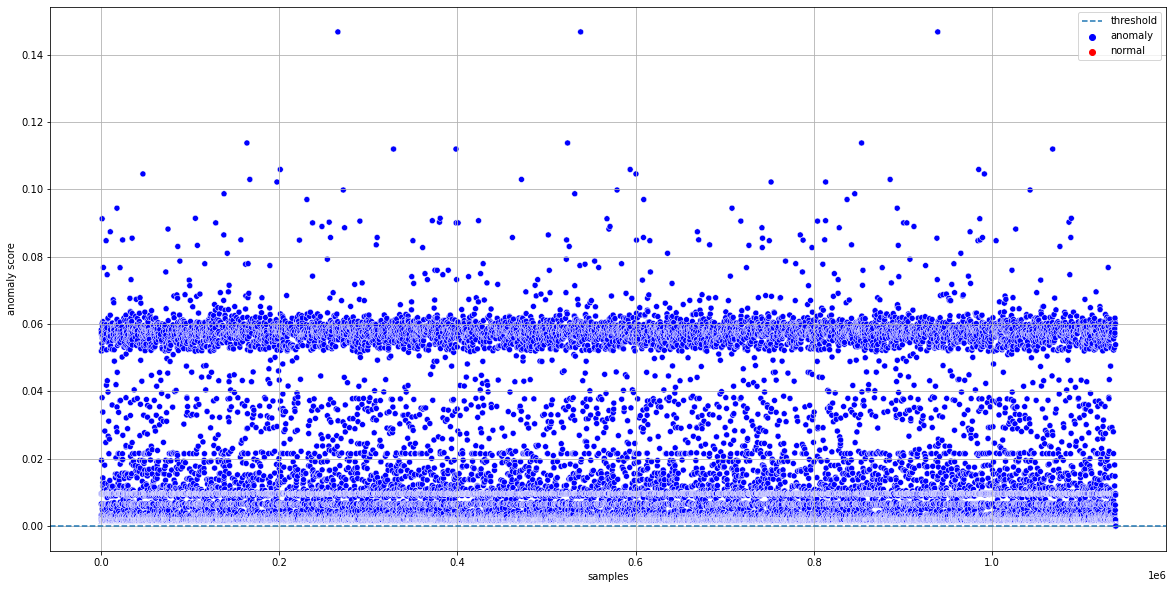

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(loss_df)), y= loss_df, hue=['normal' if i==0 else 'anomaly' for i in loss_df2],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = th, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

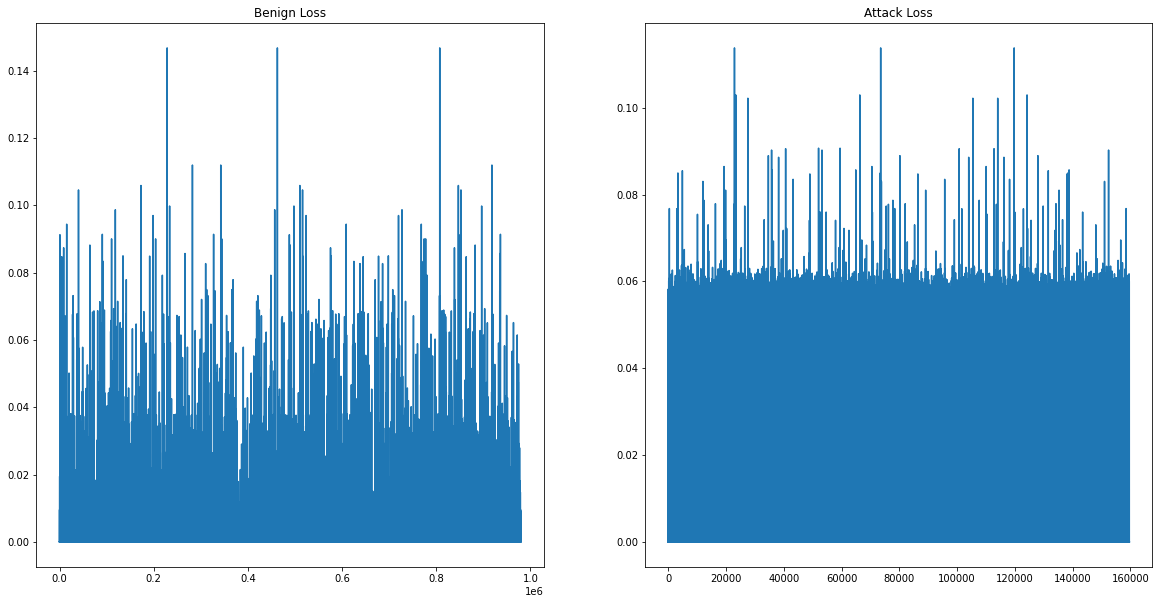

In [ ]:
zero_df = pd.DataFrame(zero)
one_df = pd.DataFrame(one)
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(zero_df)
plt.title('Benign Loss')

plt.subplot(1,2,2)
plt.plot(one_df)
plt.title('Attack Loss')

plt.show()

# Base AE Model - AutoEncoder
- code_size = 8

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# AutoEncoder
class AutoEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, code_size=8):
    super(AutoEncoder, self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim

    self.encoder = nn.Sequential(
        nn.Linear(input_dim, code_size),
        nn.BatchNorm1d(8),
        nn.ReLU(),
    )

    self.decoder = nn.Sequential(
        nn.Linear(code_size, output_dim),
        nn.Sigmoid()
    )

  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [ ]:
# Simple AE setting
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(input_dim=FEATURE_NUM, 
                    output_dim=FEATURE_NUM).to(DEVICE)
criterion = nn.MSELoss()
learning_rate = 0.0008
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=76, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=76, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
from tqdm import tqdm
from collections import defaultdict
train_losses = []

minimum = float('inf')
dic = defaultdict(int)

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
  running_loss = 0
  model.train()
  for datas in train_loader:
    data, _ = datas
    data = data.to(DEVICE)
    data = data.float()
    # ===================forward=====================
    encoded,decoded = model.forward(data)
    loss = criterion(decoded, data)

    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()

    # Step backwards
    optimizer.step()
    running_loss += loss.item()
  val = running_loss/len(train_loader)
  train_losses.append(val)

  # Early stopping
  if np.round(val,4) <= minimum : 
    minimum = np.round(val,4)
    dic[minimum] += 1
    if dic[minimum] > 3 : 
      break
  # ===================log========================
  print(f'epoch [{epoch + 1}/{num_epochs}], train loss:{val:.4f}')

 10%|█         | 1/10 [04:41<42:09, 281.06s/it]

epoch [1/10], train loss:0.0055


 20%|██        | 2/10 [09:17<37:08, 278.55s/it]

epoch [2/10], train loss:0.0001


 30%|███       | 3/10 [13:54<32:24, 277.75s/it]

epoch [3/10], train loss:0.0000


 40%|████      | 4/10 [18:31<27:45, 277.52s/it]

epoch [4/10], train loss:0.0000


 50%|█████     | 5/10 [23:07<23:04, 276.87s/it]

epoch [5/10], train loss:0.0000


 60%|██████    | 6/10 [27:54<18:41, 280.34s/it]

epoch [6/10], train loss:0.0000


 70%|███████   | 7/10 [33:05<14:31, 290.49s/it]

epoch [7/10], train loss:0.0000


 80%|████████  | 8/10 [37:54<09:39, 289.78s/it]

epoch [8/10], train loss:0.0000


 90%|█████████ | 9/10 [42:30<04:45, 285.52s/it]

epoch [9/10], train loss:0.0000


100%|██████████| 10/10 [47:05<00:00, 282.55s/it]

epoch [10/10], train loss:0.0000


In [ ]:
torch.save(model,'/content/drive/MyDrive/AD-DL Proj/model/UDP_SimpleAE_code8_B128_E10_model_udp_total_data.pt')

In [ ]:
model = torch.load('/content/drive/MyDrive/AD-DL Proj/model/UDP_SimpleAE_code8_B128_E10_model_udp_total_data.pt')

In [ ]:
# code_size = 2
# train_loss collection
from tqdm import tqdm
model.eval()

train_loss_collection = []

with torch.no_grad():
  for datases in tqdm(train_loader): 
    datas, labels = datases
    for data, label in zip(datas, labels):
      data = data.to(DEVICE)
      label = np.array(label)
      data = data.reshape(1, data.shape[0])
      encoded, decoded = model.forward(data)
      loss = criterion(decoded, data)
      loss = loss.item()
      train_loss_collection.append(loss)

len(train_loss_collection)

100%|██████████| 10201/10201 [10:27<00:00, 16.24it/s]


1305676

In [ ]:
import numpy as np
threshold = np.percentile(train_loss_collection, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
threshold

array([8.32641547e-08, 3.65785382e-07, 6.56608165e-07, 8.99852751e-07,
       1.08851850e-06, 1.33332480e-06, 1.73611238e-06, 2.20570121e-06,
       2.81576308e-06, 4.72612555e-06, 1.37077868e-01])

In [ ]:
# code_size = 8
# model
# threshold
from tqdm import tqdm
model.eval()

predicted_abnormal = []
predicted_normal = []
real_abnormal = []
real_normal = []
total_loss = []
zero = []
one = []

test_result = pd.DataFrame(columns=['tp', 'fp', 'tn', 'fn', 'acc', 'f1', 'precision', 'recall'], index=threshold)

for th in threshold:
  # evaluation initiation
  tp = fn = fp = tn = 0
  with torch.no_grad():
    for datases in tqdm(test_loader): 
      datas, labels = datases
      running_val_loss = 0 
      real_abnormal = []
      for data, label in zip(datas, labels):
        data = data.to(DEVICE)
        label = np.array(label)
        data = data.reshape(1, data.shape[0])
        encoded, decoded = model.forward(data)
        loss = criterion(decoded, data)
        loss = loss.item()
        # loss >= 0.001 ; predict as 'Abnormal'
        if loss >= th:
          # label == 0 ; real 'Normal'
          if label == 0: 
            fp += 1
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            tp += 1
            real_abnormal.append(loss)
          predicted_abnormal.append(loss)
        # loss < 0.001 ; predict as 'Normal'
        elif loss < th: 
          # label == 0 ; real 'Normal'
          if label == 0: 
            tn += 1
            real_normal.append(loss)
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            fn += 1
          predicted_normal.append(loss)
        total_loss.append(loss)
        if label == 1:
          one.append(loss)
        else:
          zero.append(loss)
  try : 
    acc = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    test_result.loc[th] = [tp, fp, tn, fn, acc, f1, precision, recall]
  except : 
    continue
test_result

100%|██████████| 2966/2966 [03:08<00:00, 15.72it/s]


,tp,fp,tn,fn,acc,f1,precision,recall
8.326415e-08,53223,326419,0,0,0.140193,0.24591,0.140193,1
3.657854e-07,47930,293559,32860,5293,0.212806,0.242861,0.140356,0.900551
6.566082e-07,41870,261150,65269,11353,0.282211,0.235064,0.138176,0.78669
8.998528e-07,36914,228617,97802,16309,0.35485,0.231614,0.13902,0.693572
1.088519e-06,31497,196136,130283,21726,0.426138,0.224293,0.138367,0.591793
1.333325e-06,26328,163340,163079,26895,0.498909,0.216789,0.138811,0.494673
1.736112e-06,21153,130425,195994,32070,0.571978,0.206571,0.139552,0.397441
2.205701e-06,16201,97584,228835,37022,0.64544,0.194015,0.142383,0.304398
2.815763e-06,11015,65415,261004,42208,0.716515,0.169915,0.144119,0.206959
4.726126e-06,6270,32869,293550,46953,0.789744,0.13577,0.160198,0.117806


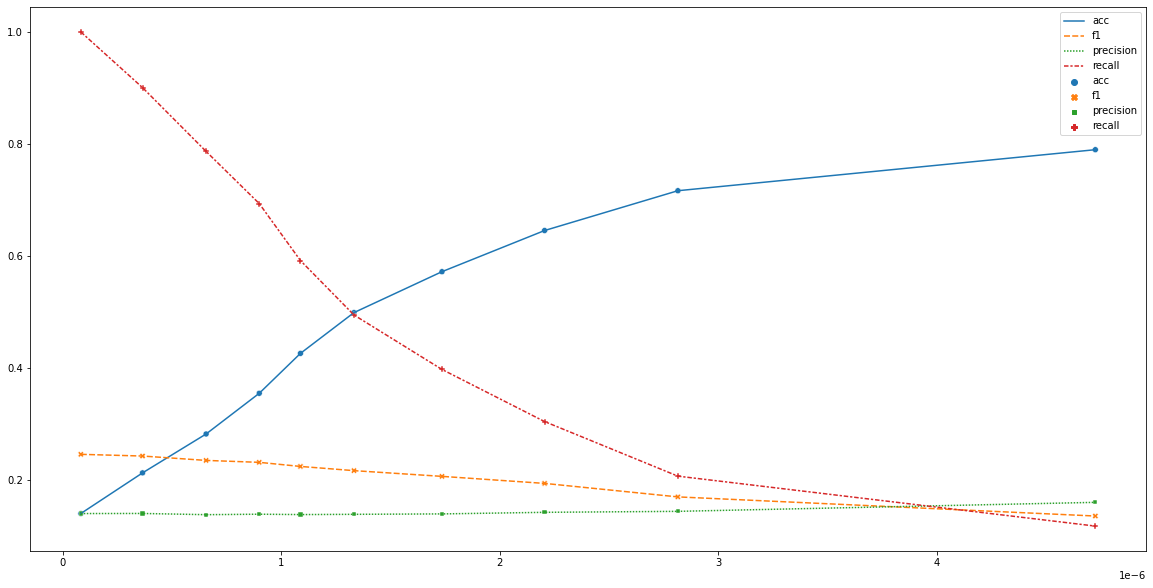

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.lineplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
sns.scatterplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
plt.show()

In [ ]:
import numpy as np
threshold = np.percentile(train_loss_collection, [5,10,15,20])
threshold

array([2.48304616e-07, 3.65785382e-07, 5.20277268e-07, 6.56608165e-07])

In [ ]:
# code_size = 8
# model
# threshold
from tqdm import tqdm
model.eval()

predicted_abnormal = []
predicted_normal = []
real_abnormal = []
real_normal = []
total_loss = []
zero = []
one = []

test_result = pd.DataFrame(columns=['tp', 'fp', 'tn', 'fn', 'acc', 'f1', 'precision', 'recall'], index=threshold)

for th in threshold:
  # evaluation initiation
  tp = fn = fp = tn = 0
  with torch.no_grad():
    for datases in tqdm(test_loader): 
      datas, labels = datases
      running_val_loss = 0 
      real_abnormal = []
      for data, label in zip(datas, labels):
        data = data.to(DEVICE)
        label = np.array(label)
        data = data.reshape(1, data.shape[0])
        encoded, decoded = model.forward(data)
        loss = criterion(decoded, data)
        loss = loss.item()
        # loss >= 0.001 ; predict as 'Abnormal'
        if loss >= th:
          # label == 0 ; real 'Normal'
          if label == 0: 
            fp += 1
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            tp += 1
            real_abnormal.append(loss)
          predicted_abnormal.append(loss)
        # loss < 0.001 ; predict as 'Normal'
        elif loss < th: 
          # label == 0 ; real 'Normal'
          if label == 0: 
            tn += 1
            real_normal.append(loss)
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            fn += 1
          predicted_normal.append(loss)
        total_loss.append(loss)
        if label == 1:
          one.append(loss)
        else:
          zero.append(loss)
  try : 
    acc = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    test_result.loc[th] = [tp, fp, tn, fn, acc, f1, precision, recall]
  except : 
    continue
test_result

100%|██████████| 2966/2966 [03:11<00:00, 15.50it/s]


,tp,fp,tn,fn,acc,f1,precision,recall
2.483046e-07,50636,309971,16448,2587,0.176703,0.244719,0.140419,0.951393
3.657854e-07,47930,293559,32860,5293,0.212806,0.242861,0.140356,0.900551
5.202773e-07,45225,277271,49148,7998,0.248584,0.240738,0.140234,0.849727
6.566082e-07,41870,261150,65269,11353,0.282211,0.235064,0.138176,0.78669


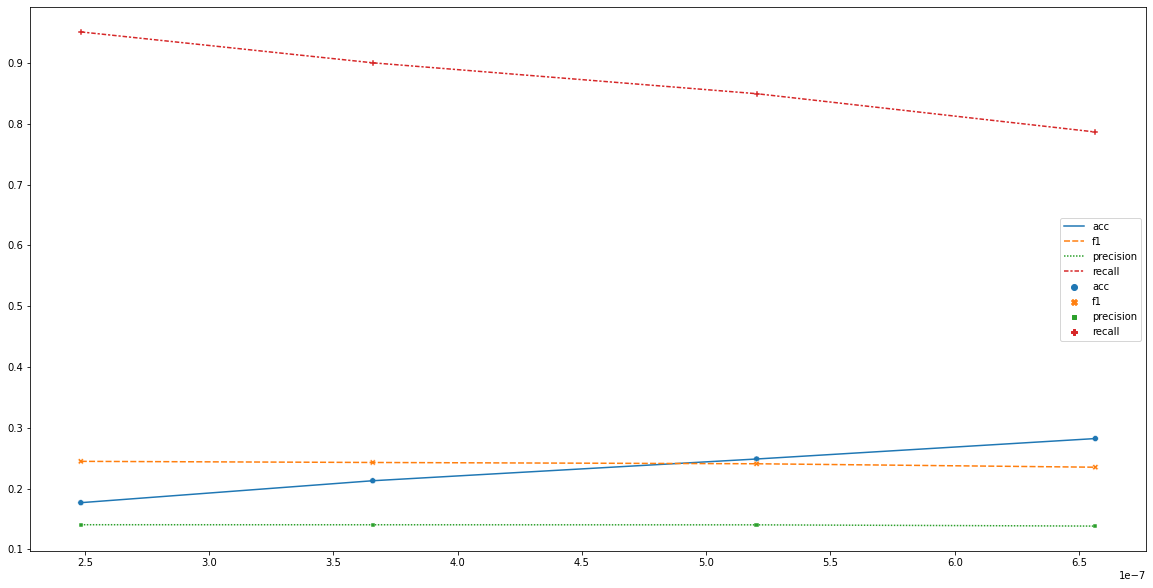

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.lineplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
sns.scatterplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


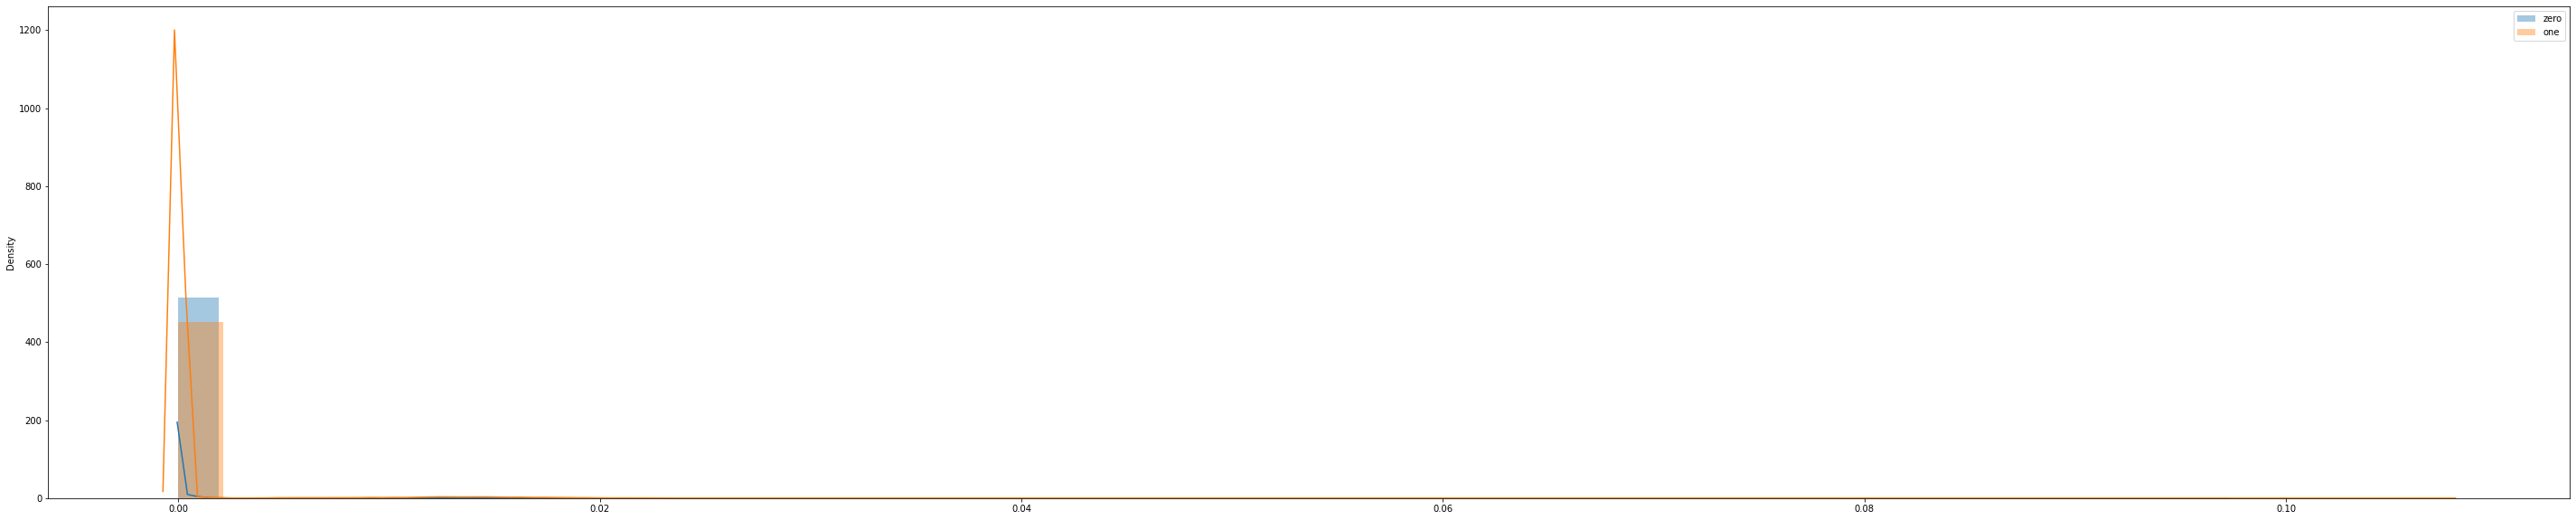

In [ ]:
plt.figure(figsize=(50, 10))
sns.distplot(zero, label='zero')
sns.distplot(one, label='one')
plt.legend()
plt.show()

In [ ]:
th = 3.657854e-07
def get_loss(x):
  global th 
  if x > th : 
    return 1
  else : 
    return 0
loss_df = pd.Series(total_loss)
loss_df2 = loss_df.apply(get_loss)

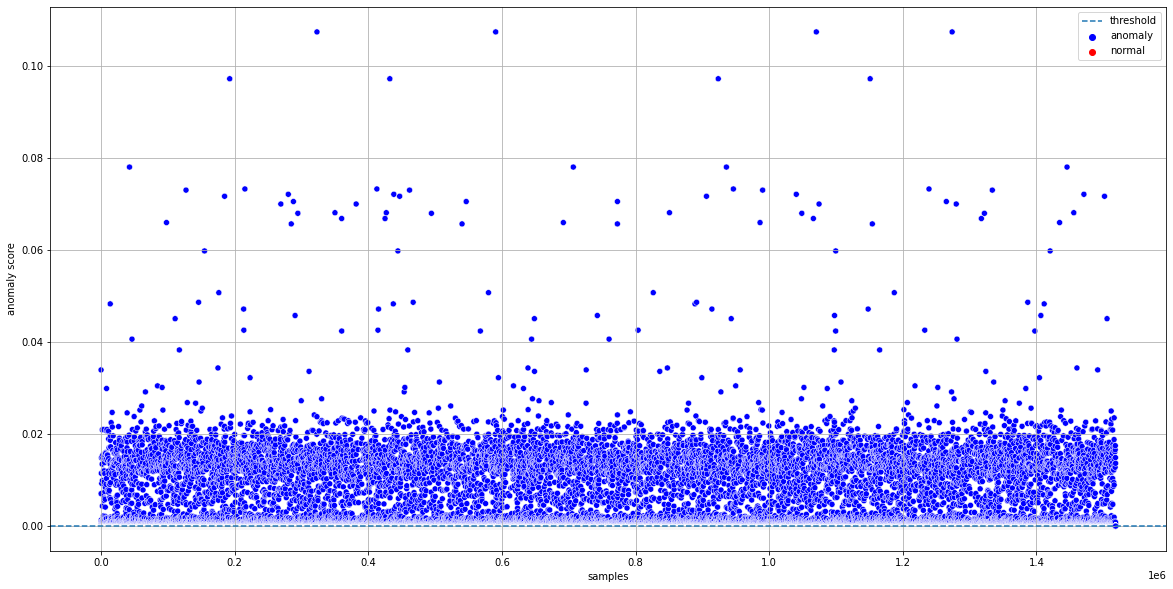

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(loss_df)), y= loss_df, hue=['normal' if i==0 else 'anomaly' for i in loss_df2],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = th, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

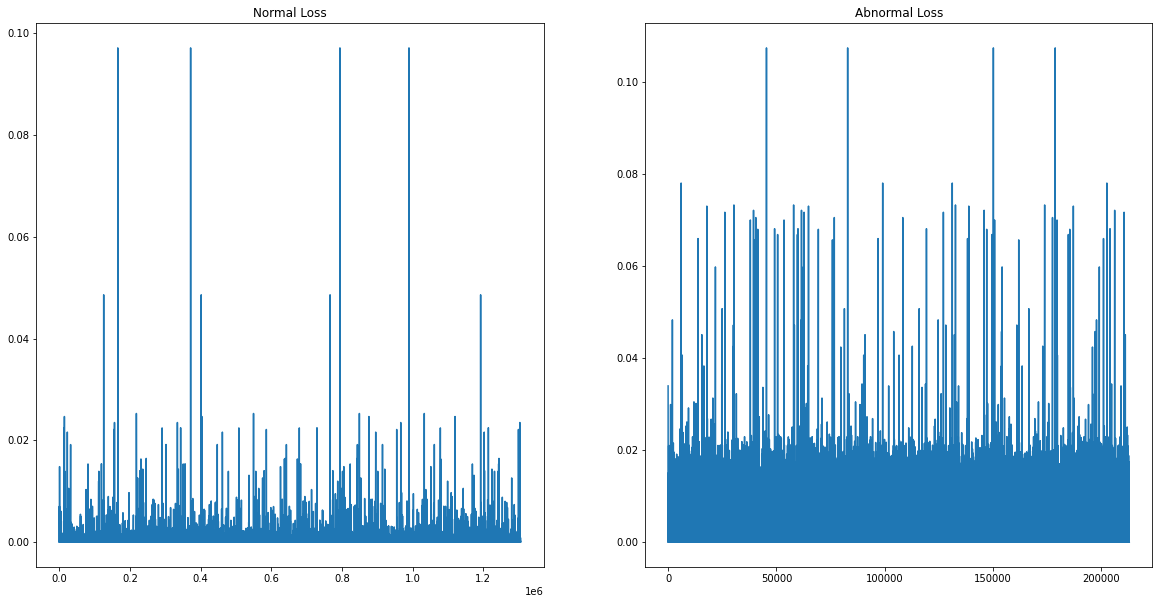

In [ ]:
zero_df = pd.DataFrame(zero)
one_df = pd.DataFrame(one)
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(zero_df)
plt.title('Normal Loss')

plt.subplot(1,2,2)
plt.plot(one_df)
plt.title('Abnormal Loss')

plt.show()

# Base AE Model - AutoEncoder
- code_size = 16

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# AutoEncoder
class AutoEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, code_size=16):
    super(AutoEncoder, self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim

    self.encoder = nn.Sequential(
        nn.Linear(input_dim, code_size),
        nn.BatchNorm1d(16),
        nn.ReLU(),
    )

    self.decoder = nn.Sequential(
        nn.Linear(code_size, output_dim),
        nn.Sigmoid()
    )

  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [ ]:
# Simple AE setting
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(input_dim=FEATURE_NUM, 
                    output_dim=FEATURE_NUM).to(DEVICE)
criterion = nn.MSELoss()
learning_rate = 0.0008
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=76, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=76, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
from tqdm import tqdm
from collections import defaultdict
train_losses = []

minimum = float('inf')
dic = defaultdict(int)

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
  running_loss = 0
  model.train()
  for datas in train_loader:
    data, _ = datas
    data = data.to(DEVICE)
    data = data.float()
    # ===================forward=====================
    encoded,decoded = model.forward(data)
    loss = criterion(decoded, data)

    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()

    # Step backwards
    optimizer.step()
    running_loss += loss.item()
  val = running_loss/len(train_loader)
  train_losses.append(val)

  # Early stopping
  if np.round(val,4) <= minimum : 
    minimum = np.round(val,4)
    dic[minimum] += 1
    if dic[minimum] > 3 : 
      break
  # ===================log========================
  print(f'epoch [{epoch + 1}/{num_epochs}], train loss:{val:.4f}')

 10%|█         | 1/10 [04:42<42:18, 282.09s/it]

epoch [1/10], train loss:0.0037


 20%|██        | 2/10 [09:21<37:23, 280.39s/it]

epoch [2/10], train loss:0.0000


 30%|███       | 3/10 [14:01<32:42, 280.29s/it]

epoch [3/10], train loss:0.0000


 40%|████      | 4/10 [18:41<28:00, 280.02s/it]

epoch [4/10], train loss:0.0000


 50%|█████     | 5/10 [23:18<23:15, 279.09s/it]

epoch [5/10], train loss:0.0000


 60%|██████    | 6/10 [28:01<18:42, 280.53s/it]

epoch [6/10], train loss:0.0000


 70%|███████   | 7/10 [32:40<14:00, 280.04s/it]

epoch [7/10], train loss:0.0000


 80%|████████  | 8/10 [37:19<09:19, 279.65s/it]

epoch [8/10], train loss:0.0000


 90%|█████████ | 9/10 [41:57<04:39, 279.01s/it]

epoch [9/10], train loss:0.0000


100%|██████████| 10/10 [46:33<00:00, 279.36s/it]

epoch [10/10], train loss:0.0000


In [ ]:
dic

defaultdict(int, {0.0: 1, 0.0037: 1})

In [ ]:
torch.save(model,'/content/drive/MyDrive/AD-DL Proj/model/UDP_SimpleAE_code16_B128_E10_model_udp_total_data.pt')

In [ ]:
model = torch.load('/content/drive/MyDrive/AD-DL Proj/model/UDP_SimpleAE_code16_B128_E10_model_udp_total_data.pt')

In [ ]:
# code_size = 16
# train_loss collection
from tqdm import tqdm
model.eval()

train_loss_collection = []

with torch.no_grad():
  for datases in tqdm(train_loader): 
    datas, labels = datases
    for data, label in zip(datas, labels):
      data = data.to(DEVICE)
      label = np.array(label)
      data = data.reshape(1, data.shape[0])
      encoded, decoded = model.forward(data)
      loss = criterion(decoded, data)
      loss = loss.item()
      train_loss_collection.append(loss)

len(train_loss_collection)

100%|██████████| 10201/10201 [10:32<00:00, 16.12it/s]


1305676

In [ ]:
import numpy as np
threshold = np.percentile(train_loss_collection, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
threshold

array([1.33367053e-07, 2.95221298e-07, 3.53171004e-07, 4.04820497e-07,
       4.83210158e-07, 5.64116760e-07, 6.90913907e-07, 8.38131939e-07,
       1.00940304e-06, 1.77952734e-06, 1.08768769e-01])

In [ ]:
# code_size = 2
# model
# threshold
from tqdm import tqdm
model.eval()

predicted_abnormal = []
predicted_normal = []
real_abnormal = []
real_normal = []
total_loss = []
zero = []
one = []

test_result = pd.DataFrame(columns=['tp', 'fp', 'tn', 'fn', 'acc', 'f1', 'precision', 'recall'], index=threshold)

for th in threshold:
  # evaluation initiation
  tp = fn = fp = tn = 0
  with torch.no_grad():
    for datases in tqdm(test_loader): 
      datas, labels = datases
      running_val_loss = 0 
      real_abnormal = []
      for data, label in zip(datas, labels):
        data = data.to(DEVICE)
        label = np.array(label)
        data = data.reshape(1, data.shape[0])
        encoded, decoded = model.forward(data)
        loss = criterion(decoded, data)
        loss = loss.item()
        # loss >= 0.001 ; predict as 'Abnormal'
        if loss >= th:
          # label == 0 ; real 'Normal'
          if label == 0: 
            fp += 1
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            tp += 1
            real_abnormal.append(loss)
          predicted_abnormal.append(loss)
        # loss < 0.001 ; predict as 'Normal'
        elif loss < th: 
          # label == 0 ; real 'Normal'
          if label == 0: 
            tn += 1
            real_normal.append(loss)
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            fn += 1
          predicted_normal.append(loss)
        total_loss.append(loss)
        if label == 1:
          one.append(loss)
        else:
          zero.append(loss)
  try : 
    acc = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    test_result.loc[th] = [tp, fp, tn, fn, acc, f1, precision, recall]
  except : 
    continue
test_result

100%|██████████| 2966/2966 [03:10<00:00, 15.53it/s]


,tp,fp,tn,fn,acc,f1,precision,recall
1.333671e-07,53223,326419,0,0,0.140193,0.24591,0.140193,1
2.952213e-07,47923,293870,32549,5300,0.211968,0.242638,0.140211,0.900419
3.531710e-07,41914,261525,64894,11309,0.281339,0.235035,0.13813,0.787517
4.048205e-07,36160,228755,97664,17063,0.352501,0.227323,0.136497,0.679406
4.832102e-07,31259,196014,130405,21964,0.425833,0.222884,0.137539,0.587321
5.641168e-07,25982,162964,163455,27241,0.498989,0.214577,0.13751,0.488172
6.909139e-07,21467,130318,196101,31756,0.573087,0.209426,0.14143,0.403341
8.381319e-07,16742,97678,228741,36481,0.646617,0.199734,0.146321,0.314563
1.009403e-06,11738,65232,261187,41485,0.718901,0.180317,0.152501,0.220544
1.779527e-06,6291,32691,293728,46932,0.790268,0.136457,0.161382,0.118201


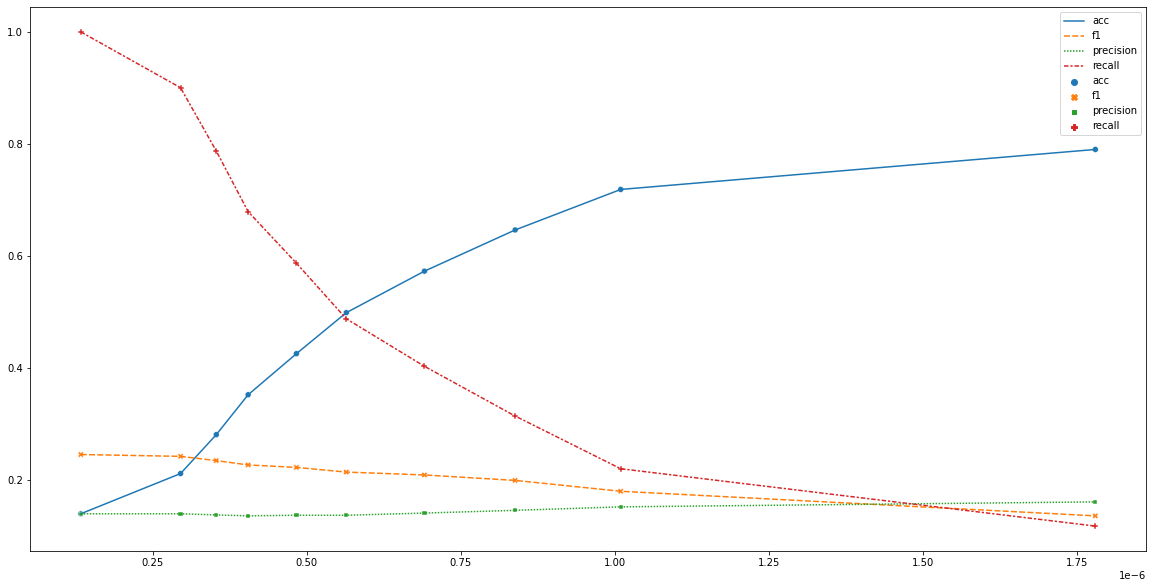

In [ ]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
sns.scatterplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
plt.show()

In [ ]:
import numpy as np
threshold = np.percentile(train_loss_collection, [33,35,38])
threshold

array([4.27682807e-07, 4.40114214e-07, 4.64459077e-07])

In [ ]:
# code_size = 2
# model
# threshold
from tqdm import tqdm
model.eval()

predicted_abnormal = []
predicted_normal = []
real_abnormal = []
real_normal = []
total_loss = []
zero = []
one = []

test_result = pd.DataFrame(columns=['tp', 'fp', 'tn', 'fn', 'acc', 'f1', 'precision', 'recall'], index=threshold)

for th in threshold:
  # evaluation initiation
  tp = fn = fp = tn = 0
  with torch.no_grad():
    for datases in tqdm(test_loader): 
      datas, labels = datases
      running_val_loss = 0 
      real_abnormal = []
      for data, label in zip(datas, labels):
        data = data.to(DEVICE)
        label = np.array(label)
        data = data.reshape(1, data.shape[0])
        encoded, decoded = model.forward(data)
        loss = criterion(decoded, data)
        loss = loss.item()
        # loss >= 0.001 ; predict as 'Abnormal'
        if loss >= th:
          # label == 0 ; real 'Normal'
          if label == 0: 
            fp += 1
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            tp += 1
            real_abnormal.append(loss)
          predicted_abnormal.append(loss)
        # loss < 0.001 ; predict as 'Normal'
        elif loss < th: 
          # label == 0 ; real 'Normal'
          if label == 0: 
            tn += 1
            real_normal.append(loss)
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            fn += 1
          predicted_normal.append(loss)
        total_loss.append(loss)
        if label == 1:
          one.append(loss)
        else:
          zero.append(loss)
  try : 
    acc = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    test_result.loc[th] = [tp, fp, tn, fn, acc, f1, precision, recall]
  except : 
    continue
test_result

100%|██████████| 2966/2966 [03:11<00:00, 15.51it/s]


,tp,fp,tn,fn,acc,f1,precision,recall
4.276828e-07,34664,219006,107413,18559,0.374239,0.225903,0.13665,0.651297
4.401142e-07,33747,212393,114026,19476,0.389243,0.225459,0.137105,0.634068
4.644591e-07,32398,202566,123853,20825,0.411575,0.22484,0.137885,0.608722


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


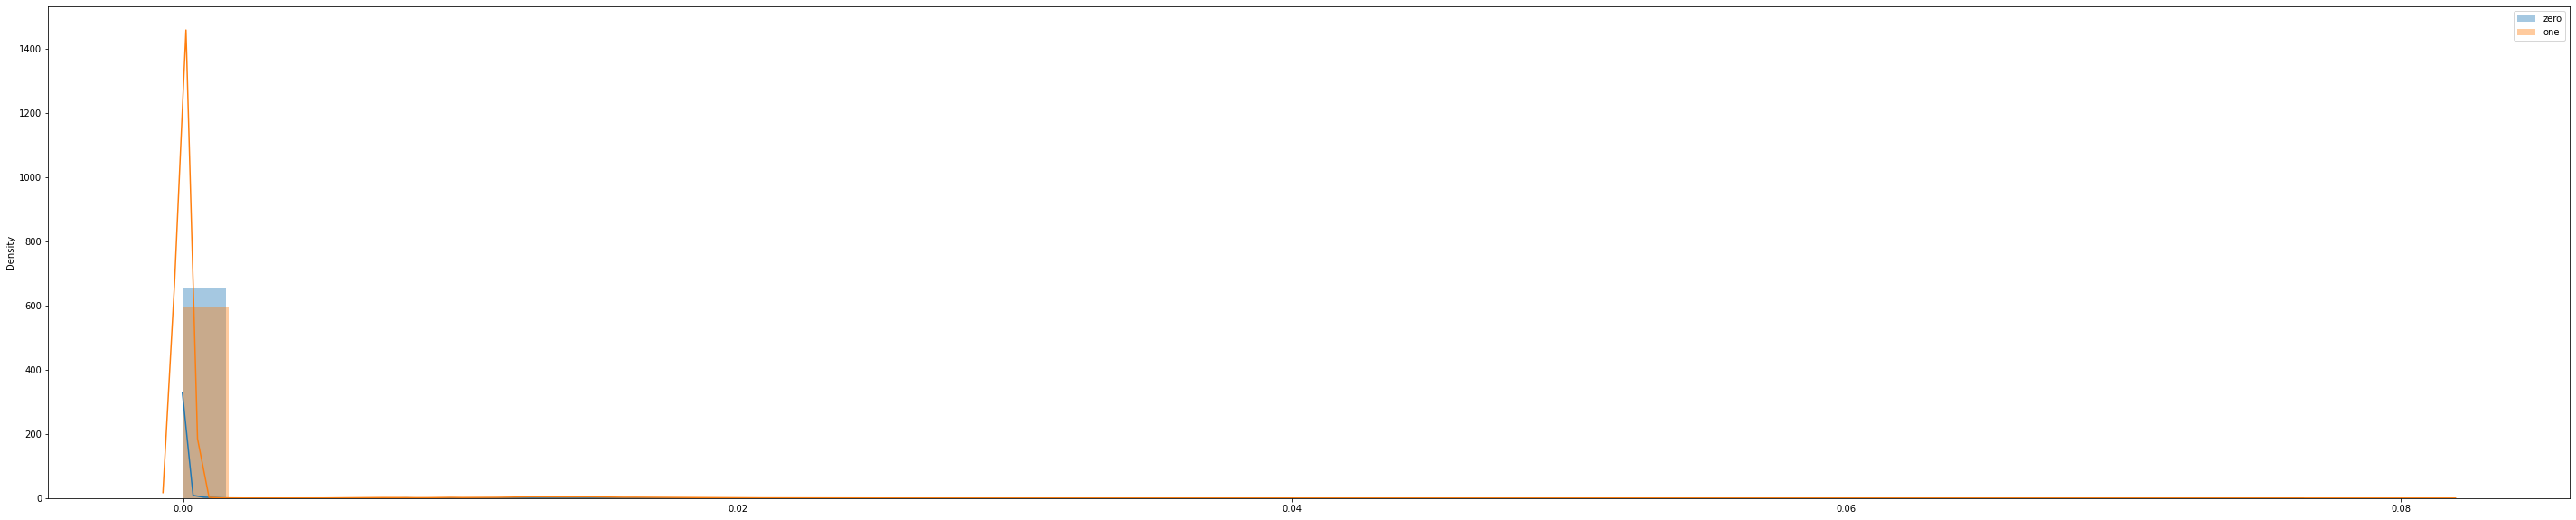

In [ ]:
plt.figure(figsize=(50, 10))
sns.distplot(zero, label='zero')
sns.distplot(one, label='one')
plt.legend()
plt.show()

In [ ]:
th = 4.644591e-07
def get_loss(x):
  global th 
  if x > th : 
    return 1
  else : 
    return 0
loss_df = pd.Series(total_loss)
loss_df2 = loss_df.apply(get_loss)

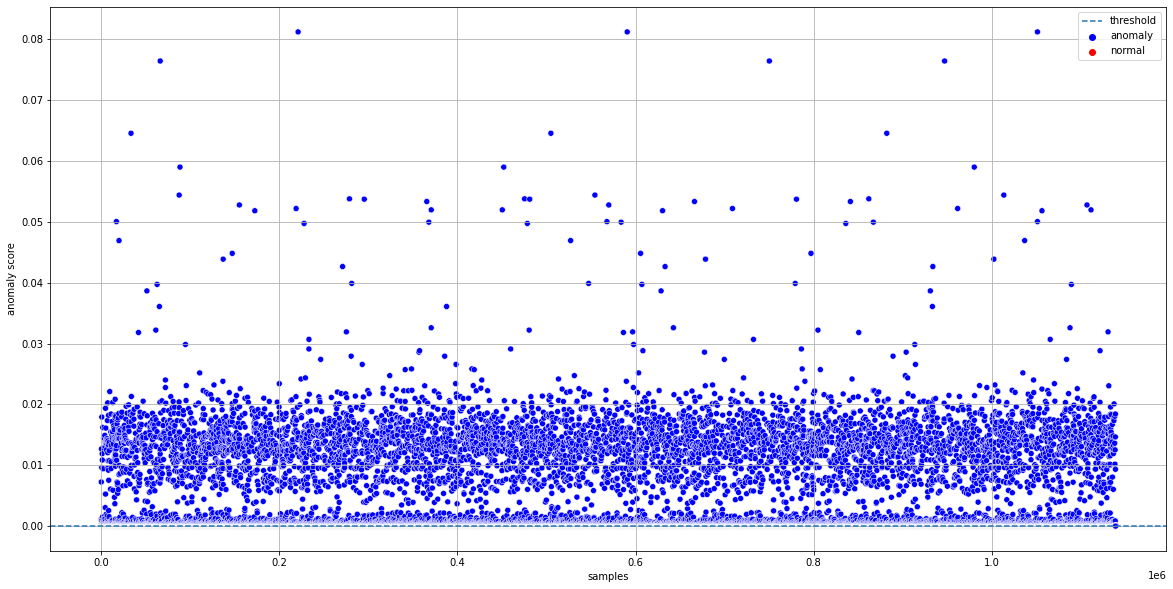

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(loss_df)), y= loss_df, hue=['normal' if i==0 else 'anomaly' for i in loss_df2],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = th, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

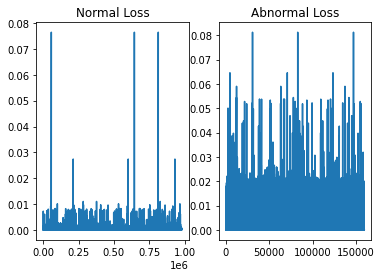

In [ ]:
zero_df = pd.DataFrame(zero)
one_df = pd.DataFrame(one)
plt.subplot(1,2,1)
plt.plot(zero_df)
plt.title('Normal Loss')

plt.subplot(1,2,2)
plt.plot(one_df)
plt.title('Abnormal Loss')

plt.show()

# Stacked AE - StackedAutoEncoder

In [ ]:
import tensorflow as tf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# AE + stack + dropout
class StackedAutoEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, code_size=2):
    super(StackedAutoEncoder, self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim

    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 16),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8, code_size)
    )

    self.decoder = nn.Sequential(
        nn.Linear(code_size, 8),
        nn.ReLU(),
        nn.Linear(8, 16),
        nn.ReLU(),
        nn.Linear(16, 64),
        nn.ReLU(),
        nn.Linear(64, output_dim),
        nn.Sigmoid()
    )

  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [ ]:
# Simple AE setting
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = StackedAutoEncoder(input_dim=FEATURE_NUM, 
                    output_dim=FEATURE_NUM).to(DEVICE)
criterion = nn.MSELoss()
learning_rate = 0.0008
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
model

StackedAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=76, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=76, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
from tqdm import tqdm
from collections import defaultdict
train_losses = []

minimum = float('inf')
dic = defaultdict(int)

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
  running_loss = 0
  model.train()
  for datas in train_loader:
    data, _ = datas
    data = data.to(DEVICE)
    data = data.float()
    # ===================forward=====================
    encoded,decoded = model.forward(data)
    loss = criterion(decoded, data)

    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()

    # Step backwards
    optimizer.step()
    running_loss += loss.item()
  val = running_loss/len(train_loader)
  train_losses.append(val)

  # Early stopping
  if np.round(val,4) <= minimum : 
    minimum = np.round(val,4)
    dic[minimum] += 1
    if dic[minimum] > 3 : 
      break
  # ===================log========================
  print(f'epoch [{epoch + 1}/{num_epochs}], train loss:{val:.4f}')

 10%|█         | 1/10 [04:52<43:49, 292.14s/it]

epoch [1/10], train loss:0.0015


 20%|██        | 2/10 [09:38<38:31, 288.91s/it]

epoch [2/10], train loss:0.0001


 30%|███       | 3/10 [14:25<33:36, 288.13s/it]

epoch [3/10], train loss:0.0001


 40%|████      | 4/10 [19:12<28:45, 287.62s/it]

epoch [4/10], train loss:0.0001


 40%|████      | 4/10 [23:58<35:58, 359.74s/it]


In [ ]:
torch.save(model,'/content/drive/MyDrive/AD-DL Proj/model/UDP_StackedAE_code2_B128_E10_model_udp_total_data.pt')

In [ ]:
model = torch.load('/content/drive/MyDrive/AD-DL Proj/model/UDP_StackedAE_code2_B128_E10_model_udp_total_data.pt')

In [ ]:
# code_size = 2
# train_loss collection
from tqdm import tqdm
model.eval()

train_loss_collection = []

with torch.no_grad():
  for datases in tqdm(train_loader): 
    datas, labels = datases
    for data, label in zip(datas, labels):
      data = data.to(DEVICE)
      label = np.array(label)
      data = data.reshape(1, data.shape[0])
      encoded, decoded = model.forward(data)
      loss = criterion(decoded, data)
      loss = loss.item()
      train_loss_collection.append(loss)

len(train_loss_collection)

100%|██████████| 10201/10201 [14:28<00:00, 11.74it/s]


1305676

In [ ]:
import numpy as np
threshold = np.percentile(train_loss_collection, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
threshold

array([5.46959200e-07, 1.63172604e-06, 4.83451322e-06, 6.58144950e-06,
       8.45279737e-06, 1.21693020e-05, 1.59093743e-05, 1.99568403e-05,
       2.57836036e-05, 4.25746784e-05, 1.27782822e-01])

In [ ]:
np.set_printoptions(precision=6, suppress=True)
a = np.array([5.46959200e-07, 1.63172604e-06, 4.83451322e-06, 6.58144950e-06,
       8.45279737e-06, 1.21693020e-05, 1.59093743e-05, 1.99568403e-05,
       2.57836036e-05, 4.25746784e-05, 1.27782822e-01])
a

array([0.000001, 0.000002, 0.000005, 0.000007, 0.000008, 0.000012,
       0.000016, 0.00002 , 0.000026, 0.000043, 0.127783])

In [ ]:
# code_size = 2
# model
# threshold
from tqdm import tqdm
model.eval()

predicted_abnormal = []
predicted_normal = []
real_abnormal = []
real_normal = []
total_loss = []
zero = []
one = []

test_result = pd.DataFrame(columns=['tp', 'fp', 'tn', 'fn', 'acc', 'f1', 'precision', 'recall'], index=threshold)

for th in threshold:
  # evaluation initiation
  tp = fn = fp = tn = 0
  with torch.no_grad():
    for datases in tqdm(test_loader): 
      datas, labels = datases
      running_val_loss = 0 
      real_abnormal = []
      for data, label in zip(datas, labels):
        data = data.to(DEVICE)
        label = np.array(label)
        data = data.reshape(1, data.shape[0])
        encoded, decoded = model.forward(data)
        loss = criterion(decoded, data)
        loss = loss.item()
        # loss >= 0.001 ; predict as 'Abnormal'
        if loss >= th:
          # label == 0 ; real 'Normal'
          if label == 0: 
            fp += 1
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            tp += 1
            real_abnormal.append(loss)
          predicted_abnormal.append(loss)
        # loss < 0.001 ; predict as 'Normal'
        elif loss < th: 
          # label == 0 ; real 'Normal'
          if label == 0: 
            tn += 1
            real_normal.append(loss)
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            fn += 1
          predicted_normal.append(loss)
        total_loss.append(loss)
        if label == 1:
          one.append(loss)
        else:
          zero.append(loss)
  try : 
    acc = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    test_result.loc[th] = [tp, fp, tn, fn, acc, f1, precision, recall]
  except : 
    continue
test_result

100%|██████████| 2966/2966 [04:17<00:00, 11.50it/s]


,tp,fp,tn,fn,acc,f1,precision,recall
5.469592e-07,53223,326419,0,0,0.140193,0.24591,0.140193,1
1.631726e-06,47963,293487,32932,5260,0.213082,0.243052,0.140469,0.901171
4.834513e-06,43000,260698,65721,10223,0.286378,0.24095,0.141588,0.807921
6.581449e-06,37262,228215,98204,15961,0.356826,0.233837,0.140359,0.700111
8.452797e-06,32026,195772,130647,21197,0.428491,0.227926,0.140589,0.601732
1.216930e-05,25870,163052,163367,27353,0.498462,0.213674,0.136935,0.486068
1.590937e-05,21139,130426,195993,32084,0.571939,0.206448,0.139472,0.397178
1.995684e-05,14789,97728,228691,38434,0.641341,0.17846,0.131438,0.277869
2.578360e-05,10324,65111,261308,42899,0.715495,0.160487,0.13686,0.193976
4.257468e-05,6632,32502,293917,46591,0.791664,0.143617,0.169469,0.124608


In [ ]:
# code_size = 2
# model

# threshold
import numpy as np
threshold = list(set(np.percentile(train_loss_collection, range(0, 101, 10))))

from tqdm import tqdm
model.eval()

predicted_abnormal = []
predicted_normal = []
real_abnormal = []
real_normal = []
total_loss = []
zero = []
one = []
f1_best = 0

test_result = pd.DataFrame(columns=['tp', 'fp', 'tn', 'fn', 'acc', 'f1', 'precision', 'recall'], index=threshold)

for th in threshold:
  zero1 = []
  one1 = []
  total_loss1 = []
  # evaluation initiation
  tp = fn = fp = tn = 0
  with torch.no_grad():
    for datases in tqdm(test_loader): 
      datas, labels = datases
      running_val_loss = 0 
      predicted_abnormal1 = []
      predicted_normal1 = []
      real_abnormal1 = []
      real_normal1 = []
      for data, label in zip(datas, labels):
        data = data.to(DEVICE)
        label = np.array(label)
        data = data.reshape(1, data.shape[0])
        encoded, decoded = model.forward(data)
        loss = criterion(decoded, data)
        loss = loss.item()
        # loss >= 0.001 ; predict as 'Abnormal'
        if loss >= th:
          # label == 0 ; real 'Normal'
          if label == 0: 
            fp += 1
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            tp += 1
            real_abnormal1.append(loss)
          predicted_abnormal1.append(loss)
        # loss < 0.001 ; predict as 'Normal'
        elif loss < th: 
          # label == 0 ; real 'Normal'
          if label == 0: 
            tn += 1
            real_normal1.append(loss)
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            fn += 1
          predicted_normal1.append(loss)
        total_loss1.append(loss)
        if label == 1:
          one1.append(loss)
        else:
          zero1.append(loss)
  try:
    acc = (tp+tn)/(tp+fn+fp+tn)
  except:
    acc = 'NaN'
  try:
    precision = tp/(tp+fp)
  except:
    precision = 'NaN'
  try:
    recall = tp/(tp+fn)
  except:
    recall = 'NaN'
  try:
    f1 = 2*(precision*recall)/(precision+recall)
  except:
    f1 = 'NaN'

  if f1 != 'NaN' and f1 > f1_best:
    f1_best = f1
    one = one1.copy()
    zero = zero1.copy()
    total_loss = total_loss1.copy()
    predicted_abnormal = predicted_abnormal1.copy()
    predicted_normal = predicted_normal1.copy()
    real_abnormal = real_abnormal1.copy()
    real_normal = real_normal1.copy()

  test_result.loc[th] = [tp, fp, tn, fn, acc, f1, precision, recall]
test_result

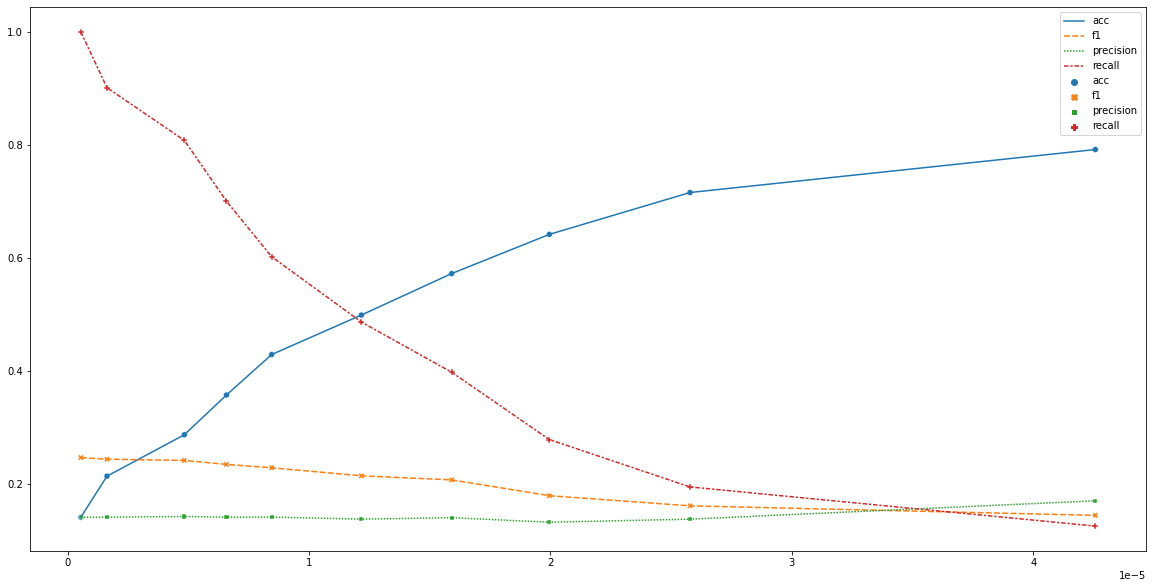

In [ ]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
sns.scatterplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


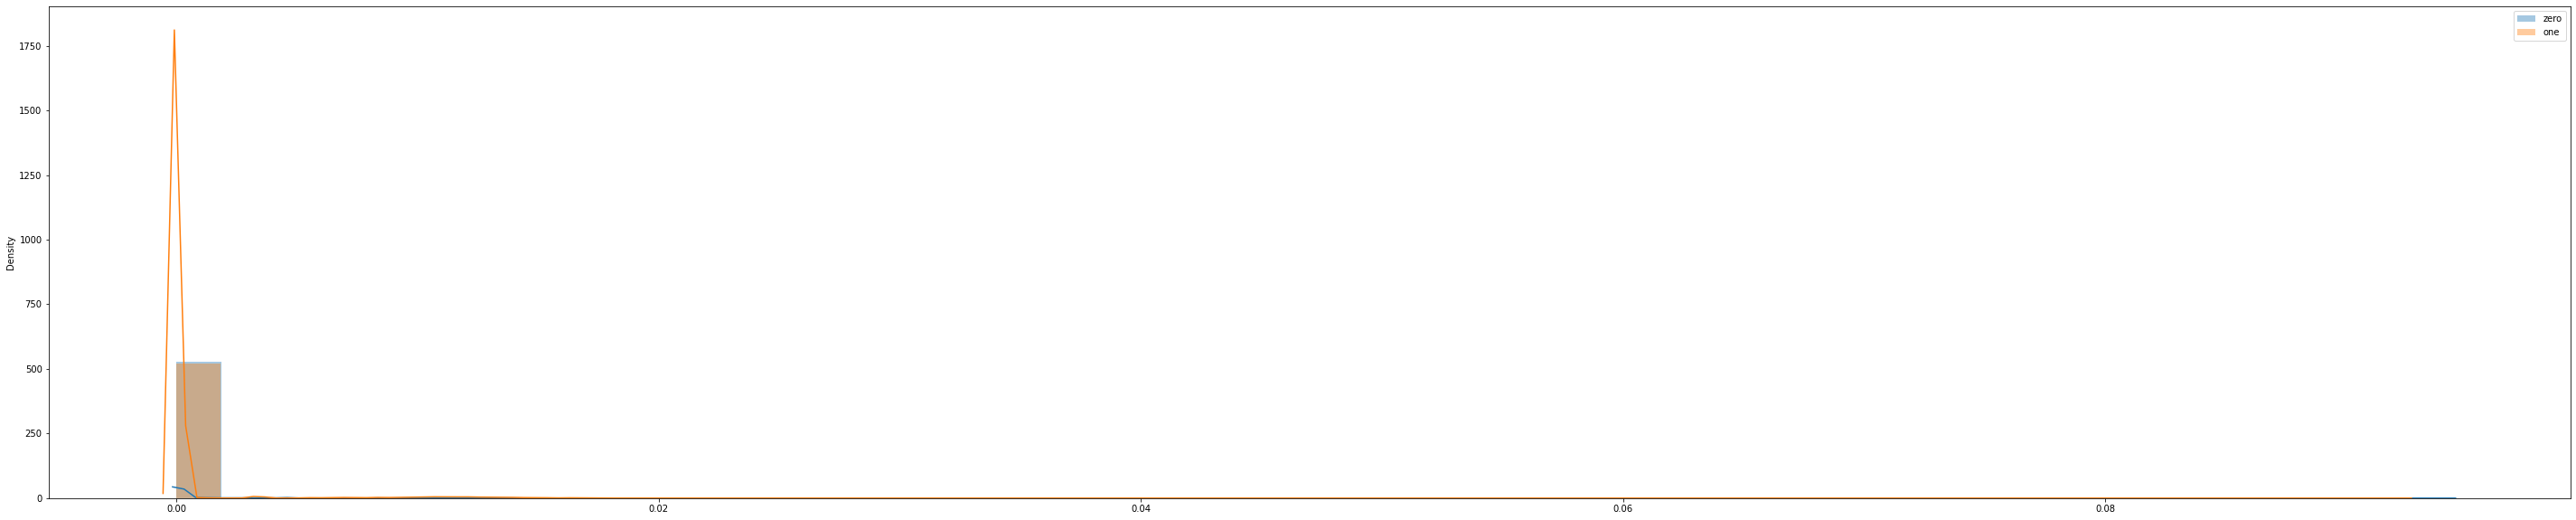

In [ ]:
plt.figure(figsize=(50, 10))
sns.distplot(zero, label='zero')
sns.distplot(one, label='one')
plt.legend()
plt.show()

In [ ]:
th = 4.834513e-06
def get_loss(x):
  global th 
  if x > th : 
    return 1
  else : 
    return 0
loss_df = pd.Series(total_loss)
loss_df2 = loss_df.apply(get_loss)

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


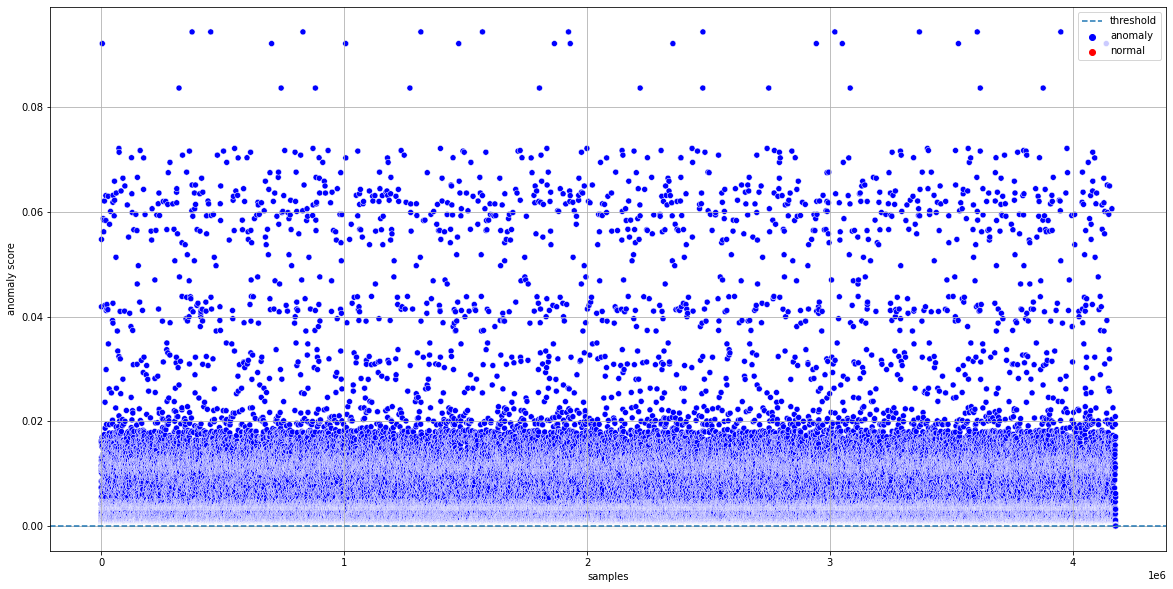

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(loss_df)), y= loss_df, hue=['normal' if i==0 else 'anomaly' for i in loss_df2],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = th, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

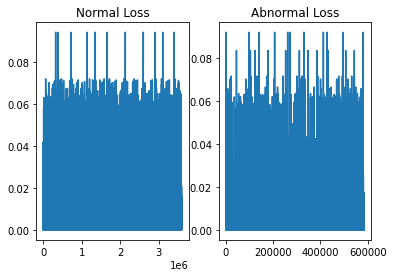

In [ ]:
zero_df = pd.DataFrame(zero)
one_df = pd.DataFrame(one)
plt.subplot(1,2,1)
plt.plot(zero_df)
plt.title('Normal Loss')

plt.subplot(1,2,2)
plt.plot(one_df)
plt.title('Abnormal Loss')

plt.show()

# Denoising AE - DenoisingAutoEncoder

In [ ]:
import tensorflow as tf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Denoising AE : input data noising + StackedAE
class DenoisingAutoEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, code_size=2):
    super(DenoisingAutoEncoder,self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim

    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 16),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8, code_size)
    )

    self.decoder = nn.Sequential(
        nn.Linear(code_size, 8),
        nn.ReLU(),
        nn.Linear(8, 16),
        nn.ReLU(),
        nn.Linear(16, 64),
        nn.ReLU(),
        nn.Linear(64, output_dim),
        nn.Sigmoid()
    )

  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [ ]:
# Simple AE setting
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DenoisingAutoEncoder(input_dim=FEATURE_NUM, 
                    output_dim=FEATURE_NUM).to(DEVICE)
criterion = nn.MSELoss()
learning_rate = 0.0008
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
model

DenoisingAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=76, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=76, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
# model_hop_denoisingae training
from tqdm import tqdm
from collections import defaultdict
train_losses = []

minimum = float('inf')
dic = defaultdict(int)


# add noise (0.2)
def add_noise(data):
    # torch.randn: Returns a tensor filled with random numbers from a normal distribution with mean 0 and variance 1
    noise = torch.randn(data.size()) * 0.2
    noisy_data = data + noise
    return noisy_data

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
  running_loss = 0
  model.train()
  for datas in train_loader:
    data, _ = datas
    noisy = add_noise(data)
    noisy = noisy.to(DEVICE)
    data = data.to(DEVICE)
    noisy = noisy.float()
    data = data.float()
    # ===================forward=====================
    encoded, decoded = model.forward(data)
    loss = criterion(decoded, data)
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()

    # Step backwards
    optimizer.step()
    running_loss += loss.item()
  val = running_loss/len(train_loader)
  train_losses.append(val)

  # Early stopping
  if np.round(val,4) <= minimum : 
    minimum = np.round(val,4)
    dic[minimum] += 1
    if dic[minimum] > 3 : 
      break
  # ===================log========================
  print(f'epoch [{epoch + 1}/{num_epochs}], train loss:{running_loss/len(train_loader):.4f}')

 10%|█         | 1/10 [04:44<42:36, 284.03s/it]

epoch [1/10], train loss:0.0001


 20%|██        | 2/10 [09:25<37:39, 282.44s/it]

epoch [2/10], train loss:0.0001


 30%|███       | 3/10 [14:05<32:51, 281.60s/it]

epoch [3/10], train loss:0.0001


 30%|███       | 3/10 [18:45<43:46, 375.26s/it]


In [ ]:
torch.save(model,'/content/drive/MyDrive/AD-DL Proj/model/UDP_DenoiseAE_code2_B128_E10_model_udp_total_data.pt')

In [ ]:
model = torch.load('/content/drive/MyDrive/AD-DL Proj/model/UDP_DenoiseAE_code2_B128_E10_model_udp_total_data.pt')

In [ ]:
# code_size = 2
# train_loss collection
from tqdm import tqdm
model.eval()

train_loss_collection = []

with torch.no_grad():
  for datases in tqdm(train_loader): 
    datas, labels = datases
    for data, label in zip(datas, labels):
      data = data.to(DEVICE)
      label = np.array(label)
      data = data.reshape(1, data.shape[0])
      encoded, decoded = model.forward(data)
      loss = criterion(decoded, data)
      loss = loss.item()
      train_loss_collection.append(loss)

len(train_loss_collection)

100%|██████████| 10201/10201 [14:08<00:00, 12.02it/s]


1305676

In [ ]:
import numpy as np
threshold = np.percentile(train_loss_collection, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
threshold

array([2.47489083e-07, 1.42637646e-06, 5.62295327e-06, 1.15396551e-05,
       2.09359659e-05, 2.48141441e-05, 2.97632014e-05, 3.82469843e-05,
       5.86834140e-05, 1.04762377e-04, 1.56108662e-01])

In [ ]:
np.set_printoptions(precision=6, suppress=True)
a=np.array([2.47489083e-07, 1.42637646e-06, 5.62295327e-06, 1.15396551e-05,
       2.09359659e-05, 2.48141441e-05, 2.97632014e-05, 3.82469843e-05,
       5.86834140e-05, 1.04762377e-04, 1.56108662e-01])
print(a)

[0.       0.000001 0.000006 0.000012 0.000021 0.000025 0.00003  0.000038
 0.000059 0.000105 0.156109]


In [ ]:
# code_size = 2
# model

# threshold
import numpy as np
threshold = list(set(np.percentile(train_loss_collection, range(0, 101, 10))))

from tqdm import tqdm
model.eval()

predicted_abnormal = []
predicted_normal = []
real_abnormal = []
real_normal = []
total_loss = []
zero = []
one = []
f1_best = 0

test_result = pd.DataFrame(columns=['tp', 'fp', 'tn', 'fn', 'acc', 'f1', 'precision', 'recall'], index=threshold)

for th in threshold:
  zero1 = []
  one1 = []
  total_loss1 = []
  # evaluation initiation
  tp = fn = fp = tn = 0
  with torch.no_grad():
    for datases in tqdm(test_loader): 
      datas, labels = datases
      running_val_loss = 0 
      predicted_abnormal1 = []
      predicted_normal1 = []
      real_abnormal1 = []
      real_normal1 = []
      for data, label in zip(datas, labels):
        data = data.to(DEVICE)
        label = np.array(label)
        data = data.reshape(1, data.shape[0])
        encoded, decoded = model.forward(data)
        loss = criterion(decoded, data)
        loss = loss.item()
        # loss >= 0.001 ; predict as 'Abnormal'
        if loss >= th:
          # label == 0 ; real 'Normal'
          if label == 0: 
            fp += 1
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            tp += 1
            real_abnormal1.append(loss)
          predicted_abnormal1.append(loss)
        # loss < 0.001 ; predict as 'Normal'
        elif loss < th: 
          # label == 0 ; real 'Normal'
          if label == 0: 
            tn += 1
            real_normal1.append(loss)
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            fn += 1
          predicted_normal1.append(loss)
        total_loss1.append(loss)
        if label == 1:
          one1.append(loss)
        else:
          zero1.append(loss)
  try : 
    acc = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    test_result.loc[th] = [tp, fp, tn, fn, acc, f1, precision, recall]
  except : 
    continue
  if f1 != 'NaN' and f1 > f1_best:
    f1_best = f1
    one = one1.copy()
    zero = zero1.copy()
    total_loss = total_loss1.copy()
    predicted_abnormal = predicted_abnormal1.copy()
    predicted_normal = predicted_normal1.copy()
    real_abnormal = real_abnormal1.copy()
    real_normal = real_normal1.copy()

  test_result.loc[th] = [tp, fp, tn, fn, acc, f1, precision, recall]
test_result

100%|██████████| 2966/2966 [04:13<00:00, 11.72it/s]


,tp,fp,tn,fn,acc,f1,precision,recall
2.474891e-07,53223,326419,0,0,0.140193,0.24591,0.140193,1
1.426376e-06,47921,293421,32998,5302,0.213146,0.242905,0.14039,0.900381
2.093597e-05,30875,195289,131130,22348,0.426731,0.22102,0.136516,0.580106
5.622953e-06,42607,260784,65635,10616,0.285116,0.238953,0.140436,0.800537
1.153966e-05,36669,228122,98297,16554,0.355509,0.230612,0.138483,0.688969
2.481414e-05,25763,162968,163451,27460,0.498401,0.212958,0.136506,0.484058
2.976320e-05,21209,130490,195929,32014,0.571955,0.206996,0.13981,0.398493
3.824698e-05,17488,97622,228797,35735,0.64873,0.207779,0.151924,0.32858
5.868341e-05,11185,65090,261329,42038,0.717818,0.172744,0.14664,0.210154
1.047624e-04,6753,32297,294122,46470,0.792523,0.14637,0.172932,0.126881


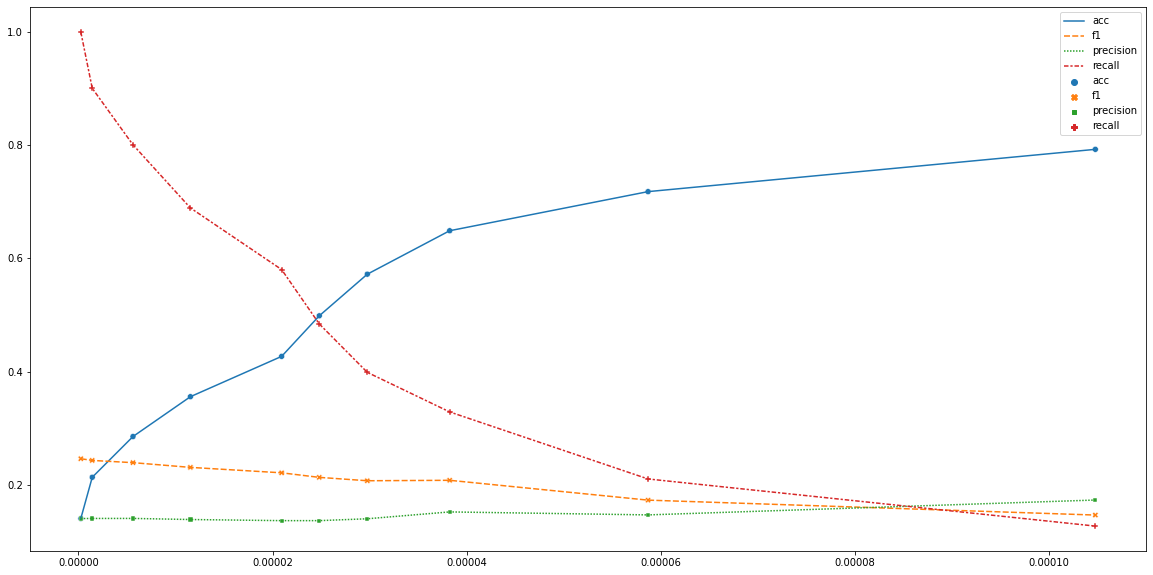

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))
sns.lineplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
sns.scatterplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


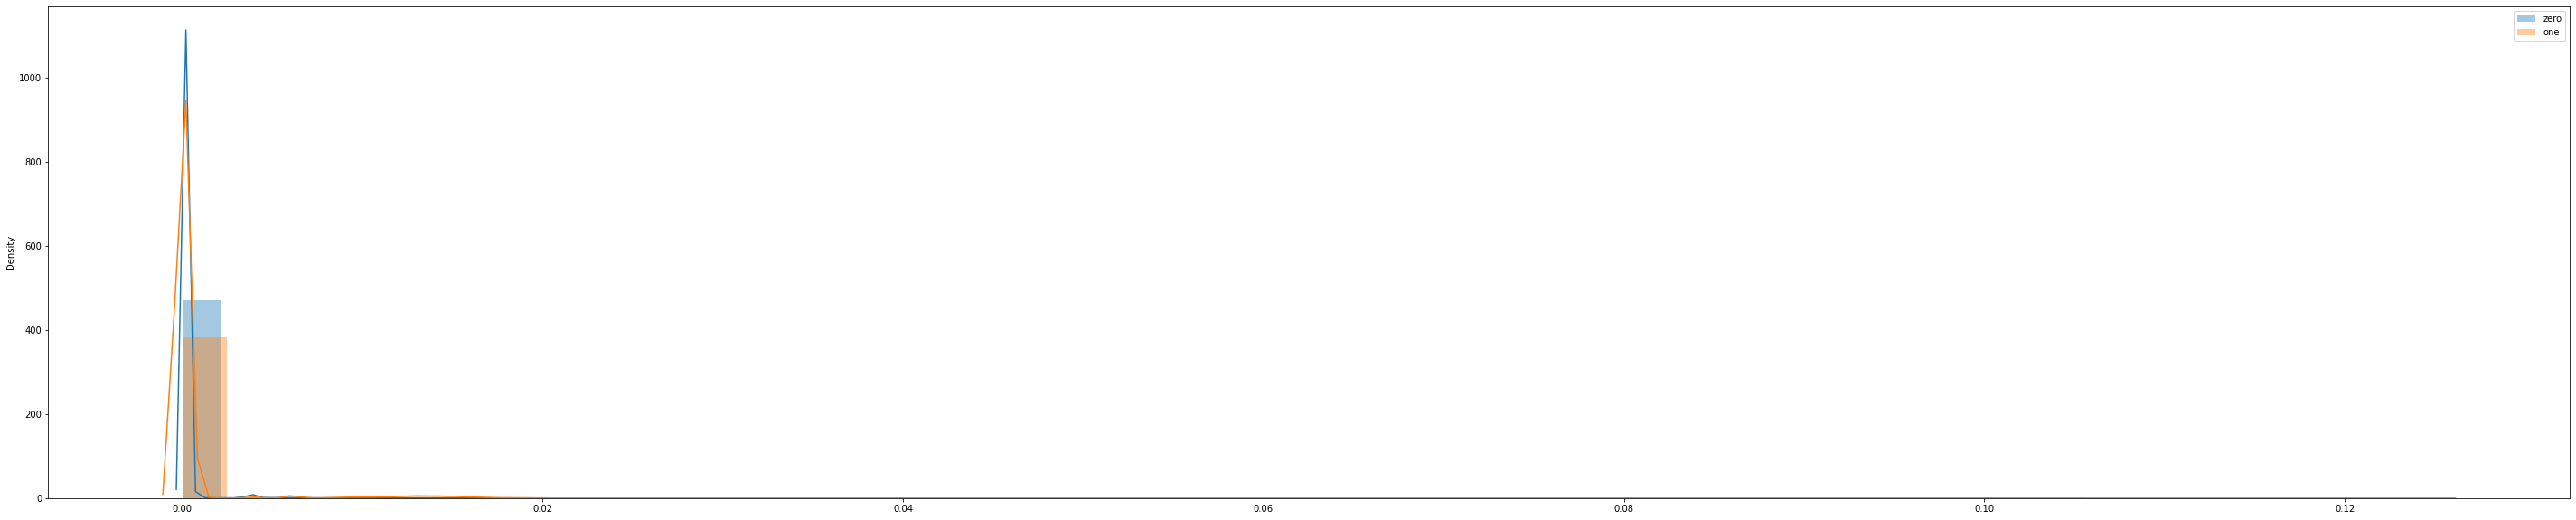

In [ ]:

plt.figure(figsize=(50, 10))
sns.distplot(zero, label='zero')
sns.distplot(one, label='one')
plt.legend()
plt.show()

In [ ]:
th = 1.426376e-06	
def get_loss(x):
  global th 
  if x > th : 
    return 1
  else : 
    return 0
loss_df = pd.Series(total_loss)
loss_df2 = loss_df.apply(get_loss)

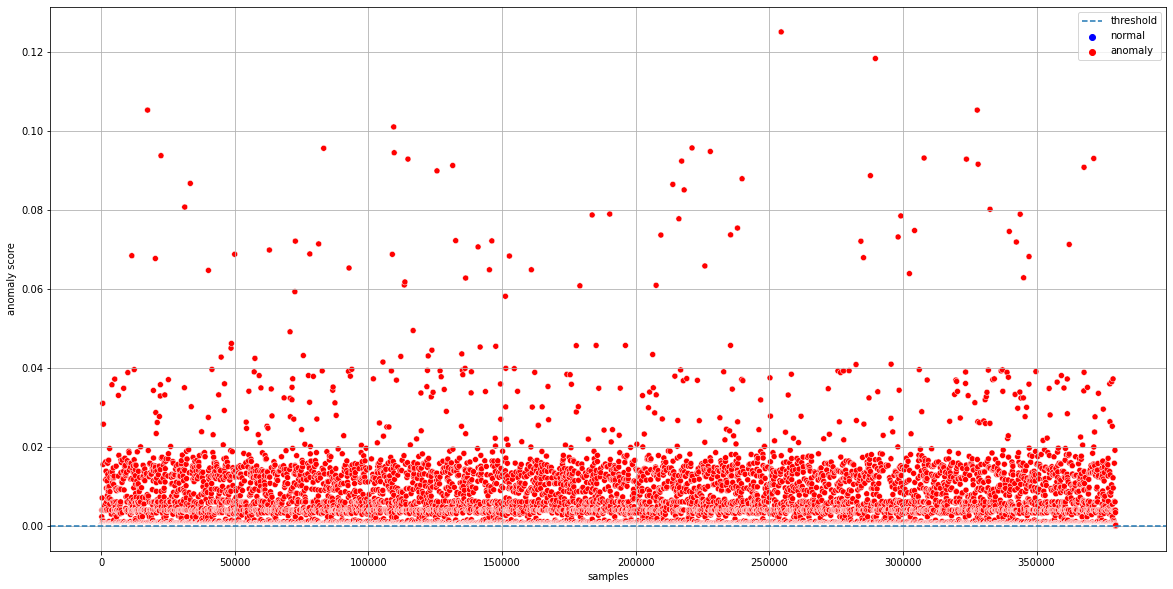

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(loss_df)), y= loss_df, hue=['normal' if i==0 else 'anomaly' for i in loss_df2],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = th, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

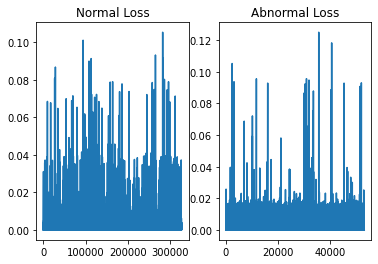

In [ ]:
zero_df = pd.DataFrame(zero)
one_df = pd.DataFrame(one)
plt.subplot(1,2,1)
plt.plot(zero_df)
plt.title('Normal Loss')

plt.subplot(1,2,2)
plt.plot(one_df)
plt.title('Abnormal Loss')

plt.show()

# Feature Selection 

In [ ]:
!pip install eli5
!pip install catboost

In [ ]:
from dask_ml.preprocessing import LabelEncoder
from dask_ml.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
udp_scale = pd.concat([X_mm,y,y_ml],axis=1)

# ML을 위해 정상, 비정상 데이터 맞춰주기
import random 
abnormal_udp = udp_scale[udp_scale['Type']==1]
normal_udp = udp_scale[udp_scale['Type']==0]
normal_idx = random.sample(list(normal_udp.index),53223)
normal_udp_sample = normal_udp.loc[normal_idx,:]

# X,y 분리
total_data_ml = pd.concat([normal_udp_sample,abnormal_udp])
total_train = total_data_ml.drop(['Type','Label'],axis=1)
total_test = total_data_ml['Label']

# 라벨 인코더 
le = LabelEncoder()
y_ml = le.fit_transform(total_test)

from dask_ml.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(total_train, y_ml, test_size=0.2, random_state=13)


In [ ]:
model = [RandomForestClassifier(),DecisionTreeClassifier(),LogisticRegression(),LGBMClassifier(),CatBoostClassifier()]

In [ ]:
from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score,precision_score
from sklearn.metrics import classification_report, confusion_matrix

feature_import = pd.DataFrame(columns = ['f1','recall','precision','column'],index=['rf','dt','lr','lgbm','cat'])
name = ['rf','dt','lr','lgbm','cat']
for idx,m in tqdm(enumerate(model)):
  model_fit = m.fit(X_train,y_train)
  y_pred = m.predict(X_test)
  f1 = f1_score(y_test,y_pred,average='micro')
  recall = recall_score(y_test,y_pred,average='micro')
  precision = precision_score(y_test,y_pred,average='micro')

  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  
  perm = PermutationImportance(model_fit,scoring='f1_micro',random_state=13).fit(X_test,y_test)

  temp = eli5.explain_weights_df(perm)
  important_cols = temp[temp['weight']>0]['feature'].map(lambda x : int(x.replace('x',''))).values
  #print(important_cols)
  column = X_train.columns[important_cols].values
  #print(column)
  
  feature_import.loc[name[idx]] = [f1,recall,precision,column]

0it [00:00, ?it/s]

[[6466    8    0    0 4148]
 [   4   29    0    0    0]
 [   0    0    2    0    0]
 [   0    0    0  327    0]
 [3679    0    0    0 6627]]
              precision    recall  f1-score   support

           0       0.64      0.61      0.62     10622
           1       0.78      0.88      0.83        33
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00       327
           4       0.62      0.64      0.63     10306

    accuracy                           0.63     21290
   macro avg       0.81      0.83      0.82     21290
weighted avg       0.63      0.63      0.63     21290



/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
1it [03:54, 234.12s/it]

[[6528   10    1    0 4083]
 [   6   27    0    0    0]
 [   0    0    2    0    0]
 [   0    0    0  327    0]
 [4522    0    0    0 5784]]
              precision    recall  f1-score   support

           0       0.59      0.61      0.60     10622
           1       0.73      0.82      0.77        33
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00       327
           4       0.59      0.56      0.57     10306

    accuracy                           0.60     21290
   macro avg       0.71      0.80      0.75     21290
weighted avg       0.59      0.60      0.59     21290



/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
2it [04:03, 101.93s/it]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318

[[6032    0    0    0 4590]
 [  33    0    0    0    0]
 [   2    0    0    0    0]
 [   4    0    0  323    0]
 [5177    0    0    0 5129]]
              precision    recall  f1-score   support

           0       0.54      0.57      0.55     10622
           1       0.00      0.00      0.00        33
           2       0.00      0.00      0.00         2
           3       1.00      0.99      0.99       327
           4       0.53      0.50      0.51     10306

    accuracy                           0.54     21290
   macro avg       0.41      0.41      0.41     21290
weighted avg       0.54      0.54      0.54     21290



/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
3it [04:17, 61.60s/it] 

[[6392   24    3  103 4100]
 [   8   25    0    0    0]
 [   1    1    0    0    0]
 [   0    0    0  327    0]
 [4554    3    1   71 5677]]
              precision    recall  f1-score   support

           0       0.58      0.60      0.59     10622
           1       0.47      0.76      0.58        33
           2       0.00      0.00      0.00         2
           3       0.65      1.00      0.79       327
           4       0.58      0.55      0.57     10306

    accuracy                           0.58     21290
   macro avg       0.46      0.58      0.51     21290
weighted avg       0.58      0.58      0.58     21290



/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
4it [06:33, 91.13s/it]

Learning rate set to 0.099258
0:	learn: 1.4618043	total: 117ms	remaining: 1m 57s
1:	learn: 1.3485537	total: 177ms	remaining: 1m 28s
2:	learn: 1.2572375	total: 235ms	remaining: 1m 17s
3:	learn: 1.1815311	total: 295ms	remaining: 1m 13s
4:	learn: 1.1184482	total: 360ms	remaining: 1m 11s
5:	learn: 1.0646530	total: 419ms	remaining: 1m 9s
6:	learn: 1.0184262	total: 477ms	remaining: 1m 7s
7:	learn: 0.9795393	total: 536ms	remaining: 1m 6s
8:	learn: 0.9450495	total: 590ms	remaining: 1m 4s
9:	learn: 0.9146625	total: 647ms	remaining: 1m 4s
10:	learn: 0.8878276	total: 713ms	remaining: 1m 4s
11:	learn: 0.8644799	total: 772ms	remaining: 1m 3s
12:	learn: 0.8441556	total: 836ms	remaining: 1m 3s
13:	learn: 0.8259758	total: 891ms	remaining: 1m 2s
14:	learn: 0.8094631	total: 951ms	remaining: 1m 2s
15:	learn: 0.7944661	total: 1.02s	remaining: 1m 2s
16:	learn: 0.7812566	total: 1.07s	remaining: 1m 2s
17:	learn: 0.7694259	total: 1.14s	remaining: 1m 1s
18:	learn: 0.7587595	total: 1.21s	remaining: 1m 2s
19:	le

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks

In [ ]:
feature_import

,f1,recall,precision,column
rf,0.631799,0.631799,0.631799,"[Pkt Len Mean, Pkt Len Var, Pkt Len Std, Bwd P..."
dt,0.595021,0.595021,0.595021,"[Bwd Pkts/s, Pkt Size Avg, Pkt Len Mean, Flow ..."
lr,0.539408,0.539408,0.539408,"[Bwd Pkt Len Max, Bwd Seg Size Avg, Bwd Pkt Le..."
lgbm,0.583419,0.583419,0.583419,"[Pkt Size Avg, TotLen Bwd Pkts, Pkt Len Mean, ..."
cat,0.653828,0.653828,0.653828,"[Pkt Len Std, Pkt Len Mean, Pkt Size Avg, Pkt ..."


# RandomForest


In [ ]:
rf_cols = ['Pkt Len Mean', 'Pkt Len Var' ,'Pkt Len Std' ,'Bwd Pkt Len Min' ,'Pkt Len Max' ,'Fwd Pkt Len Min', 'Bwd Pkt Len Max' ,'Pkt Size Avg', 'Bwd Seg Size Avg', 'Bwd Pkt Len Mean', 'Pkt Len Min', 'Bwd IAT Mean' ,'Fwd IAT Min', 'Subflow Bwd Byts', 'TotLen Bwd Pkts', 'Fwd IAT Tot', 'Subflow Bwd Pkts' ,'Fwd IAT Mean', 'Fwd Pkt Len Max' ,'Flow IAT Std' ,'Fwd Pkt Len Mean' ,'Subflow Fwd Pkts' ,'Bwd Header Len' ,'Fwd Header Len', 'Fwd Pkt Len Std' ,'Down/Up Ratio' ,'Tot Bwd Pkts', 'Fwd Act Data Pkts', 'Active Min' ,'Bwd IAT Std']

In [ ]:
len(rf_cols)

30

In [ ]:
# 학습 : 정상 135만개 
# 테스트 : 정상 33만개, 비정상 5.3만개 
normal_X = normal_udp[rf_cols]
normal_y = normal_udp['Type']

from dask_ml.model_selection import train_test_split
normal_train_X ,normal_test_X, normal_train_y, normal_test_y = train_test_split(normal_X, normal_y, test_size=0.2, random_state=13)


abnormal_X = abnormal_udp[rf_cols]
abnormal_y = abnormal_udp['Type']


test_X = pd.concat([normal_test_X,abnormal_X])
test_y = pd.concat([normal_test_y,abnormal_y])

In [ ]:
test_data_effort = pd.concat([test_X,test_y],axis=1)
test_data_effort = test_data_effort.sample(frac=1)

test_X = test_data_effort.drop('Type',axis=1)
test_y = test_data_effort['Type']

In [ ]:
from torch.utils.data import DataLoader

len(normal_train_X),len(test_X),len(normal_train_y),len(test_y)
normal_train_X = get_new_idx(normal_train_X)
normal_train_y = get_new_idx(normal_train_y)
tot_test_X = get_new_idx(test_X)
tot_test_y = get_new_idx(test_y)

# to_tensor and dataloader
BATCH_SIZE = 128
train_loader = DataLoader(CustomDataset(normal_train_X, normal_train_y), BATCH_SIZE, shuffle=True)
test_loader = DataLoader(CustomDataset(tot_test_X, tot_test_y), BATCH_SIZE, shuffle=True)

In [ ]:
import torch
for data in train_loader:
  BATCH_SIZE, FEATURE_NUM = data[0].shape
  break

print(BATCH_SIZE, FEATURE_NUM)

128 30


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# AutoEncoder
class AutoEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, code_size=2):
    super(AutoEncoder, self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim

    self.encoder = nn.Sequential(
        nn.Linear(input_dim, code_size),
        nn.BatchNorm1d(2),
        nn.ReLU(),
    )

    self.decoder = nn.Sequential(
        nn.Linear(code_size, output_dim),
        nn.Sigmoid()
    )

  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [ ]:
# Simple AE setting
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(input_dim=FEATURE_NUM, 
                    output_dim=FEATURE_NUM).to(DEVICE)
criterion = nn.MSELoss()
learning_rate = 0.0008
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
from tqdm import tqdm
from collections import defaultdict
train_losses = []

minimum = float('inf')
dic = defaultdict(int)

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
  running_loss = 0
  model.train()
  for datas in train_loader:
    data, _ = datas
    data = data.to(DEVICE)
    data = data.float()
    # ===================forward=====================
    encoded,decoded = model.forward(data)
    loss = criterion(decoded, data)

    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()

    # Step backwards
    optimizer.step()
    running_loss += loss.item()
  val = running_loss/len(train_loader)
  train_losses.append(val)

  # Early stopping
  if np.round(val,4) <= minimum : 
    minimum = np.round(val,4)
    dic[minimum] += 1
    if dic[minimum] > 3 : 
      break
  # ===================log========================
  print(f'epoch [{epoch + 1}/{num_epochs}], train loss:{val:.4f}')

 10%|█         | 1/10 [04:48<43:19, 288.82s/it]

epoch [1/10], train loss:0.0104


 20%|██        | 2/10 [09:18<37:01, 277.69s/it]

epoch [2/10], train loss:0.0003


 30%|███       | 3/10 [13:44<31:45, 272.18s/it]

epoch [3/10], train loss:0.0003


 40%|████      | 4/10 [18:10<26:58, 269.75s/it]

epoch [4/10], train loss:0.0002


 50%|█████     | 5/10 [22:35<22:20, 268.20s/it]

epoch [5/10], train loss:0.0002


 60%|██████    | 6/10 [27:01<17:48, 267.22s/it]

epoch [6/10], train loss:0.0002


 70%|███████   | 7/10 [31:26<13:20, 266.70s/it]

epoch [7/10], train loss:0.0002


 80%|████████  | 8/10 [35:52<08:52, 266.28s/it]

epoch [8/10], train loss:0.0002


 90%|█████████ | 9/10 [40:17<04:26, 266.04s/it]

epoch [9/10], train loss:0.0002


100%|██████████| 10/10 [44:43<00:00, 268.30s/it]

epoch [10/10], train loss:0.0002


In [ ]:
torch.save(model,'/content/drive/MyDrive/AD-DL Proj/model/UDP_RF_SimpleAE_code8_B128_E10_model_udp_total_data.pt')

In [ ]:
model = torch.load('/content/drive/MyDrive/AD-DL Proj/model/UDP_RF_SimpleAE_code8_B128_E10_model_udp_total_data.pt')

In [ ]:
# code_size = 2
# train_loss collection
from tqdm import tqdm
model.eval()

train_loss_collection = []

with torch.no_grad():
  for datases in tqdm(train_loader): 
    datas, labels = datases
    for data, label in zip(datas, labels):
      data = data.to(DEVICE)
      label = np.array(label)
      data = data.reshape(1, data.shape[0])
      encoded, decoded = model.forward(data)
      loss = criterion(decoded, data)
      loss = loss.item()
      train_loss_collection.append(loss)

len(train_loss_collection)

100%|██████████| 10201/10201 [10:28<00:00, 16.24it/s]


1305676

In [ ]:
import numpy as np
threshold = np.percentile(train_loss_collection, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
threshold

array([1.06851712e-06, 5.14428029e-06, 8.34061848e-06, 1.24346443e-05,
       1.80885818e-05, 2.45217079e-05, 2.83051140e-05, 3.52549723e-05,
       4.52328532e-05, 8.68614879e-05, 2.58383185e-01])

In [ ]:
# code_size = 2
# model

# threshold
import numpy as np
threshold = list(set(np.percentile(train_loss_collection, range(0, 101, 10))))

from tqdm import tqdm
model.eval()

predicted_abnormal = []
predicted_normal = []
real_abnormal = []
real_normal = []
total_loss = []
zero = []
one = []
f1_best = 0

test_result = pd.DataFrame(columns=['tp', 'fp', 'tn', 'fn', 'acc', 'f1', 'precision', 'recall'], index=threshold)

for th in threshold:
  zero1 = []
  one1 = []
  total_loss1 = []
  # evaluation initiation
  tp = fn = fp = tn = 0
  with torch.no_grad():
    for datases in tqdm(test_loader): 
      datas, labels = datases
      running_val_loss = 0 
      predicted_abnormal1 = []
      predicted_normal1 = []
      real_abnormal1 = []
      real_normal1 = []
      for data, label in zip(datas, labels):
        data = data.to(DEVICE)
        label = np.array(label)
        data = data.reshape(1, data.shape[0])
        encoded, decoded = model.forward(data)
        loss = criterion(decoded, data)
        loss = loss.item()
        # loss >= 0.001 ; predict as 'Abnormal'
        if loss >= th:
          # label == 0 ; real 'Normal'
          if label == 0: 
            fp += 1
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            tp += 1
            real_abnormal1.append(loss)
          predicted_abnormal1.append(loss)
        # loss < 0.001 ; predict as 'Normal'
        elif loss < th: 
          # label == 0 ; real 'Normal'
          if label == 0: 
            tn += 1
            real_normal1.append(loss)
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            fn += 1
          predicted_normal1.append(loss)
        total_loss1.append(loss)
        if label == 1:
          one1.append(loss)
        else:
          zero1.append(loss)
  try : 
    acc = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    test_result.loc[th] = [tp, fp, tn, fn, acc, f1, precision, recall]
  except : 
    continue
  if f1 != 'NaN' and f1 > f1_best:
    f1_best = f1
    one = one1.copy()
    zero = zero1.copy()
    total_loss = total_loss1.copy()
    predicted_abnormal = predicted_abnormal1.copy()
    predicted_normal = predicted_normal1.copy()
    real_abnormal = real_abnormal1.copy()
    real_normal = real_normal1.copy()

  test_result.loc[th] = [tp, fp, tn, fn, acc, f1, precision, recall]
test_result

100%|██████████| 2966/2966 [03:08<00:00, 15.76it/s]


,tp,fp,tn,fn,acc,f1,precision,recall
0.000001,53223,326419,0,0,0.140193,0.24591,0.140193,1
0.000005,47971,293872,32547,5252,0.212089,0.242851,0.140331,0.901321
0.000018,33691,197916,128503,19532,0.427229,0.236569,0.145466,0.633016
0.000008,42762,261464,64955,10461,0.283733,0.239262,0.14056,0.80345
0.000012,37543,228472,97947,15680,0.356889,0.235204,0.141131,0.705391
0.000025,26822,163222,163197,26401,0.500522,0.220515,0.141136,0.503955
0.000028,21997,130622,195797,31226,0.573683,0.213727,0.14413,0.413299
0.000035,17517,97949,228470,35706,0.647945,0.207684,0.151707,0.329125
0.000045,12368,69406,257013,40855,0.709566,0.183234,0.151246,0.232381
0.000087,5336,32781,293638,47887,0.787516,0.116838,0.13999,0.100257


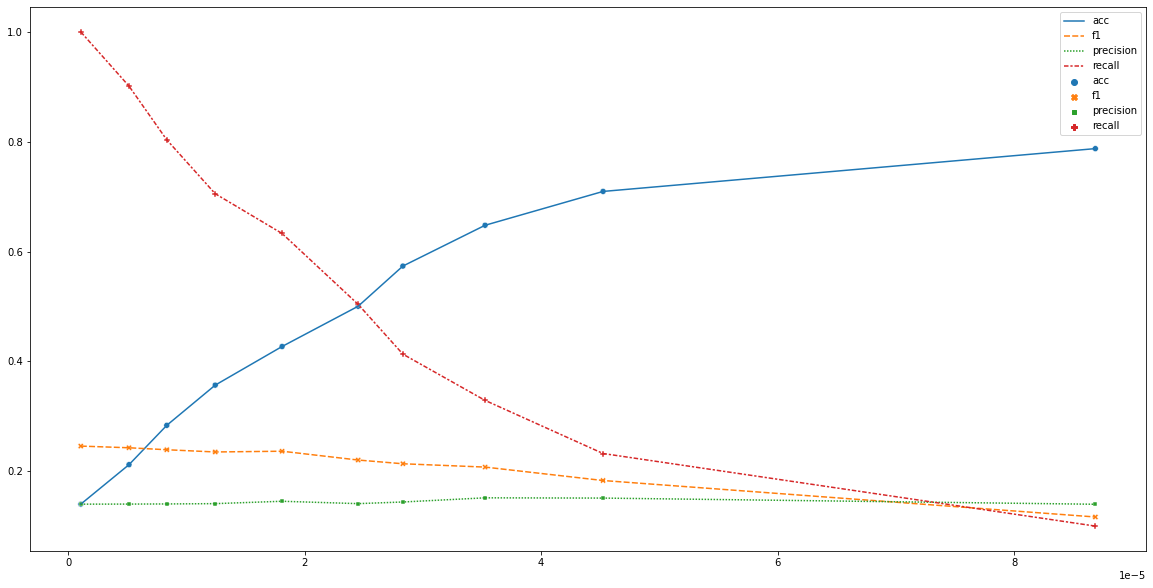

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.lineplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
sns.scatterplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


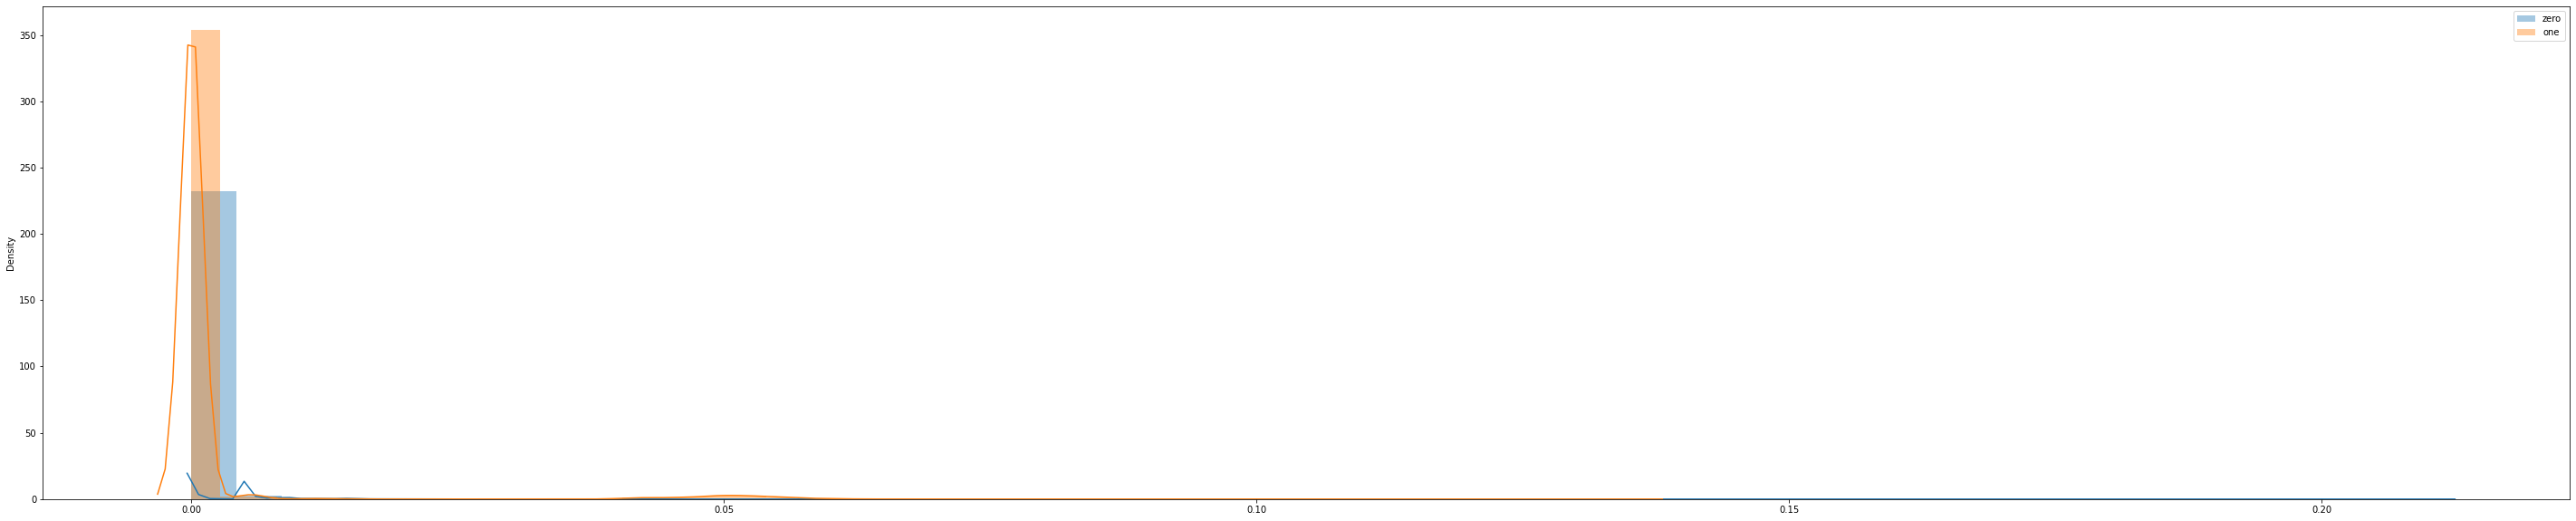

In [ ]:
plt.figure(figsize=(50, 10))
sns.distplot(zero, label='zero')
sns.distplot(one, label='one')
plt.legend()
plt.show()

In [ ]:
th = 0.000005
def get_loss(x):
  global th 
  if x > th : 
    return 1
  else : 
    return 0
loss_df = pd.Series(total_loss)
loss_df2 = loss_df.apply(get_loss)

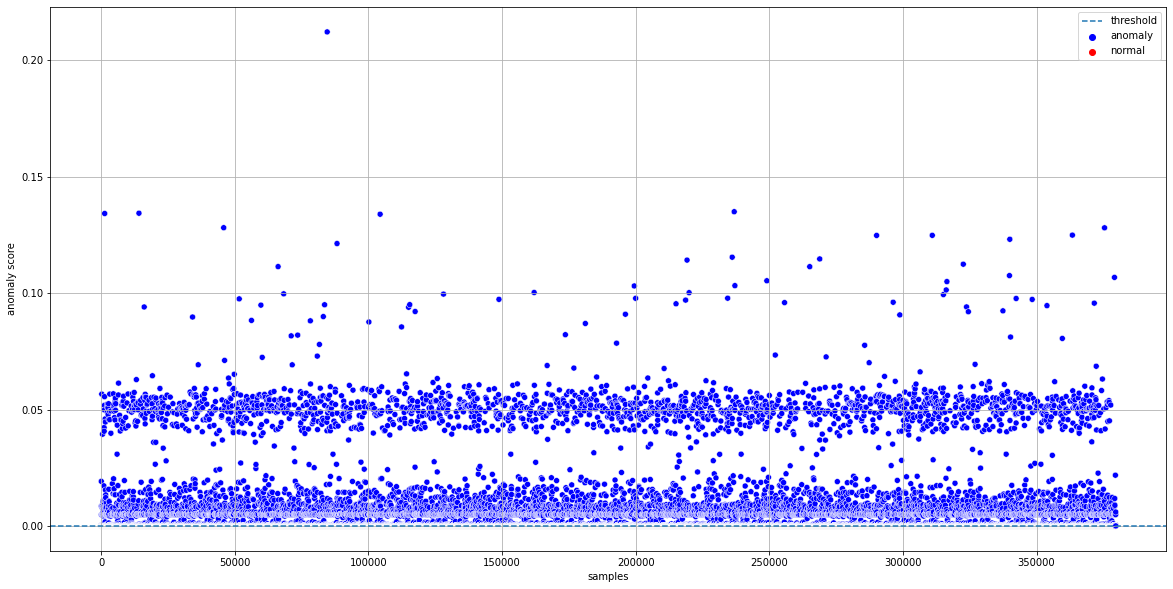

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(loss_df)), y= loss_df, hue=['normal' if i==0 else 'anomaly' for i in loss_df2],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = th, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

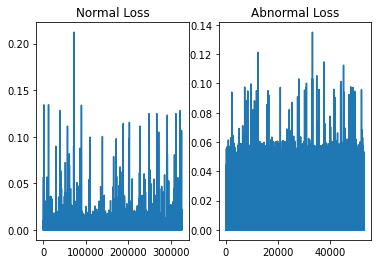

In [ ]:
plt.figure(figsize=(12,10))
zero_df = pd.DataFrame(zero)
one_df = pd.DataFrame(one)
plt.subplot(1,2,1)
plt.plot(zero_df)
plt.title('Normal Loss')

plt.subplot(1,2,2)
plt.plot(one_df)
plt.title('Abnormal Loss')

plt.show()

# Catboost

In [ ]:
cat_cols = ['Pkt Len Std', 'Pkt Len Mean', 'Pkt Size Avg', 'Pkt Len Var', 'Bwd Pkt Len Min', 'Pkt Len Max', 'Bwd Pkt Len Max' ,'Flow IAT Min', 'TotLen Bwd Pkts' ,'Fwd Pkt Len Max' ,'Fwd Pkt Len Min' ,'Bwd Pkt Len Mean', 'TotLen Fwd Pkts', 'Fwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Mean', 'Bwd Pkts/s', 'Bwd Seg Size Avg' ,'Fwd Seg Size Avg', 'Subflow Bwd Byts', 'Flow Duration', 'Fwd IAT Min', 'Pkt Len Min', 'Fwd IAT Mean', 'Flow IAT Std', 'Fwd IAT Std', 'Bwd IAT Max', 'Subflow Fwd Byts', 'Fwd IAT Tot', 'Fwd Pkts/s', 'Bwd IAT Min', 'Idle Mean', 'Fwd IAT Max', 'Flow Pkts/s', 'Active Mean', 'Flow IAT Max', 'Idle Max', 'Bwd IAT Tot', 'Active Max', 'Active Min', 'Bwd IAT Mean', 'Idle Std', 'Idle Min', 'Tot Fwd Pkts', 'Fwd Act Data Pkts', 'Down/Up Ratio', 'Subflow Fwd Pkts', 'Bwd IAT Std', 'Fwd Header Len']

In [ ]:
len(cat_cols)

49

In [ ]:
# 학습 : 정상 135만개 
# 테스트 : 정상 33만개, 비정상 5.3만개 
normal_X = normal_udp[cat_cols]
normal_y = normal_udp['Type']

from dask_ml.model_selection import train_test_split
normal_train_X ,normal_test_X, normal_train_y, normal_test_y = train_test_split(normal_X, normal_y, test_size=0.2, random_state=13)


abnormal_X = abnormal_udp[cat_cols]
abnormal_y = abnormal_udp['Type']


test_X = pd.concat([normal_test_X,abnormal_X])
test_y = pd.concat([normal_test_y,abnormal_y])

In [ ]:
test_data_effort = pd.concat([test_X,test_y],axis=1)
test_data_effort = test_data_effort.sample(frac=1)

test_X = test_data_effort.drop('Type',axis=1)
test_y = test_data_effort['Type']

In [ ]:
from torch.utils.data import DataLoader

len(normal_train_X),len(test_X),len(normal_train_y),len(test_y)
normal_train_X = get_new_idx(normal_train_X)
normal_train_y = get_new_idx(normal_train_y)
tot_test_X = get_new_idx(test_X)
tot_test_y = get_new_idx(test_y)

# to_tensor and dataloader
BATCH_SIZE = 128
train_loader = DataLoader(CustomDataset(normal_train_X, normal_train_y), BATCH_SIZE, shuffle=True)
test_loader = DataLoader(CustomDataset(tot_test_X, tot_test_y), BATCH_SIZE, shuffle=True)

In [ ]:
import torch
for data in train_loader:
  BATCH_SIZE, FEATURE_NUM = data[0].shape
  break

print(BATCH_SIZE, FEATURE_NUM)

128 49


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# AutoEncoder
class AutoEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, code_size=2):
    super(AutoEncoder, self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim

    self.encoder = nn.Sequential(
        nn.Linear(input_dim, code_size),
        nn.BatchNorm1d(2),
        nn.ReLU(),
    )

    self.decoder = nn.Sequential(
        nn.Linear(code_size, output_dim),
        nn.Sigmoid()
    )

  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [ ]:
# Simple AE setting
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(input_dim=FEATURE_NUM, 
                    output_dim=FEATURE_NUM).to(DEVICE)
criterion = nn.MSELoss()
learning_rate = 0.0008
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=49, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=49, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
from tqdm import tqdm
from collections import defaultdict
train_losses = []

minimum = float('inf')
dic = defaultdict(int)

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
  running_loss = 0
  model.train()
  for datas in train_loader:
    data, _ = datas
    data = data.to(DEVICE)
    data = data.float()
    # ===================forward=====================
    encoded,decoded = model.forward(data)
    loss = criterion(decoded, data)

    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()

    # Step backwards
    optimizer.step()
    running_loss += loss.item()
  val = running_loss/len(train_loader)
  train_losses.append(val)

  # Early stopping
  if np.round(val,4) <= minimum : 
    minimum = np.round(val,4)
    dic[minimum] += 1
    if dic[minimum] > 3 : 
      break
  # ===================log========================
  print(f'epoch [{epoch + 1}/{num_epochs}], train loss:{val:.4f}')

 10%|█         | 1/10 [04:35<41:17, 275.27s/it]

epoch [1/10], train loss:0.0112


 20%|██        | 2/10 [09:05<36:19, 272.41s/it]

epoch [2/10], train loss:0.0004


 30%|███       | 3/10 [13:31<31:27, 269.58s/it]

epoch [3/10], train loss:0.0003


 40%|████      | 4/10 [17:58<26:51, 268.55s/it]

epoch [4/10], train loss:0.0003


 50%|█████     | 5/10 [22:25<22:18, 267.78s/it]

epoch [5/10], train loss:0.0002


 60%|██████    | 6/10 [26:54<17:52, 268.18s/it]

epoch [6/10], train loss:0.0002


 70%|███████   | 7/10 [31:21<13:23, 267.97s/it]

epoch [7/10], train loss:0.0002


 70%|███████   | 7/10 [35:50<15:21, 307.15s/it]


In [ ]:
torch.save(model,'/content/drive/MyDrive/AD-DL Proj/model/UDP_CAT_SimpleAE_code8_B128_E10_model_udp_total_data.pt')

In [ ]:
model = torch.load('/content/drive/MyDrive/AD-DL Proj/model/UDP_CAT_SimpleAE_code8_B128_E10_model_udp_total_data.pt')

In [ ]:
# Simple AE setting
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load('/content/drive/MyDrive/AD-DL Proj/model/UDP_CAT_SimpleAE_code8_B128_E10_model_udp_total_data.pt')
criterion = nn.MSELoss()
learning_rate = 0.0008
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=49, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=49, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
# code_size = 2
# train_loss collection
from tqdm import tqdm
model.eval()

train_loss_collection = []

with torch.no_grad():
  for datases in tqdm(train_loader): 
    datas, labels = datases
    for data, label in zip(datas, labels):
      data = data.to(DEVICE)
      label = np.array(label)
      data = data.reshape(1, data.shape[0])
      encoded, decoded = model.forward(data)
      loss = criterion(decoded, data)
      loss = loss.item()
      train_loss_collection.append(loss)

len(train_loss_collection)

100%|██████████| 10201/10201 [16:14<00:00, 10.46it/s]


1305676

In [ ]:
import numpy as np
threshold = np.percentile(train_loss_collection, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
threshold

array([6.62979232e-07, 3.55124178e-06, 6.05120113e-06, 1.01857531e-05,
       1.29194268e-05, 1.55011567e-05, 1.90179417e-05, 2.32470702e-05,
       3.15103680e-05, 5.56420455e-05, 2.50792533e-01])

In [ ]:
# code_size = 2
# model

# threshold
import numpy as np
threshold = list(set(np.percentile(train_loss_collection, range(0, 101, 10))))

from tqdm import tqdm
model.eval()

predicted_abnormal = []
predicted_normal = []
real_abnormal = []
real_normal = []
total_loss = []
zero = []
one = []
f1_best = 0

test_result = pd.DataFrame(columns=['tp', 'fp', 'tn', 'fn', 'acc', 'f1', 'precision', 'recall'], index=threshold)

for th in threshold:
  zero1 = []
  one1 = []
  total_loss1 = []
  # evaluation initiation
  tp = fn = fp = tn = 0
  with torch.no_grad():
    for datases in tqdm(test_loader): 
      datas, labels = datases
      running_val_loss = 0 
      predicted_abnormal1 = []
      predicted_normal1 = []
      real_abnormal1 = []
      real_normal1 = []
      for data, label in zip(datas, labels):
        data = data.to(DEVICE)
        label = np.array(label)
        data = data.reshape(1, data.shape[0])
        encoded, decoded = model.forward(data)
        loss = criterion(decoded, data)
        loss = loss.item()
        # loss >= 0.001 ; predict as 'Abnormal'
        if loss >= th:
          # label == 0 ; real 'Normal'
          if label == 0: 
            fp += 1
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            tp += 1
            real_abnormal1.append(loss)
          predicted_abnormal1.append(loss)
        # loss < 0.001 ; predict as 'Normal'
        elif loss < th: 
          # label == 0 ; real 'Normal'
          if label == 0: 
            tn += 1
            real_normal1.append(loss)
          # label == 1 ; real 'Abnormal'
          elif label == 1: 
            fn += 1
          predicted_normal1.append(loss)
        total_loss1.append(loss)
        if label == 1:
          one1.append(loss)
        else:
          zero1.append(loss)
  try : 
    acc = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    test_result.loc[th] = [tp, fp, tn, fn, acc, f1, precision, recall]
  except : 
    continue
  if f1 != 'NaN' and f1 > f1_best:
    f1_best = f1
    one = one1.copy()
    zero = zero1.copy()
    total_loss = total_loss1.copy()
    predicted_abnormal = predicted_abnormal1.copy()
    predicted_normal = predicted_normal1.copy()
    real_abnormal = real_abnormal1.copy()
    real_normal = real_normal1.copy()

  test_result.loc[th] = [tp, fp, tn, fn, acc, f1, precision, recall]
test_result

100%|██████████| 2966/2966 [04:47<00:00, 10.32it/s]


,tp,fp,tn,fn,acc,f1,precision,recall
6.629792e-07,53223,326418,1,0,0.140195,0.245911,0.140193,1
3.551242e-06,48342,294316,32103,4881,0.211897,0.244225,0.141079,0.908292
1.291943e-05,32045,195553,130866,21178,0.429117,0.228224,0.140796,0.602089
6.051201e-06,43290,261420,64999,9933,0.28524,0.241889,0.14207,0.81337
1.018575e-05,38068,228554,97865,15155,0.358056,0.23804,0.142779,0.715255
1.550116e-05,26708,162715,163704,26515,0.501557,0.22014,0.140997,0.501813
1.901794e-05,21516,130330,196089,31707,0.573185,0.209842,0.141696,0.404261
2.324707e-05,15280,97712,228707,37943,0.642677,0.183858,0.135231,0.287094
3.151037e-05,10205,65202,261217,43018,0.714942,0.158672,0.135332,0.19174
5.564205e-05,5450,32666,293753,47773,0.788119,0.119336,0.142985,0.102399


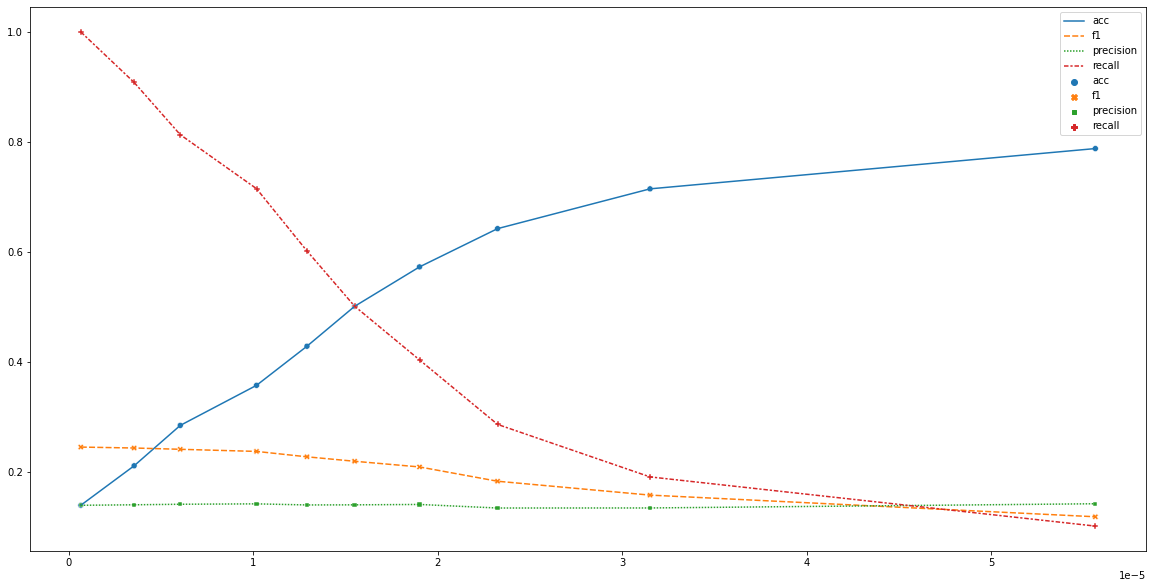

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.lineplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
sns.scatterplot(data=test_result[['acc', 'f1', 'precision', 'recall']])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


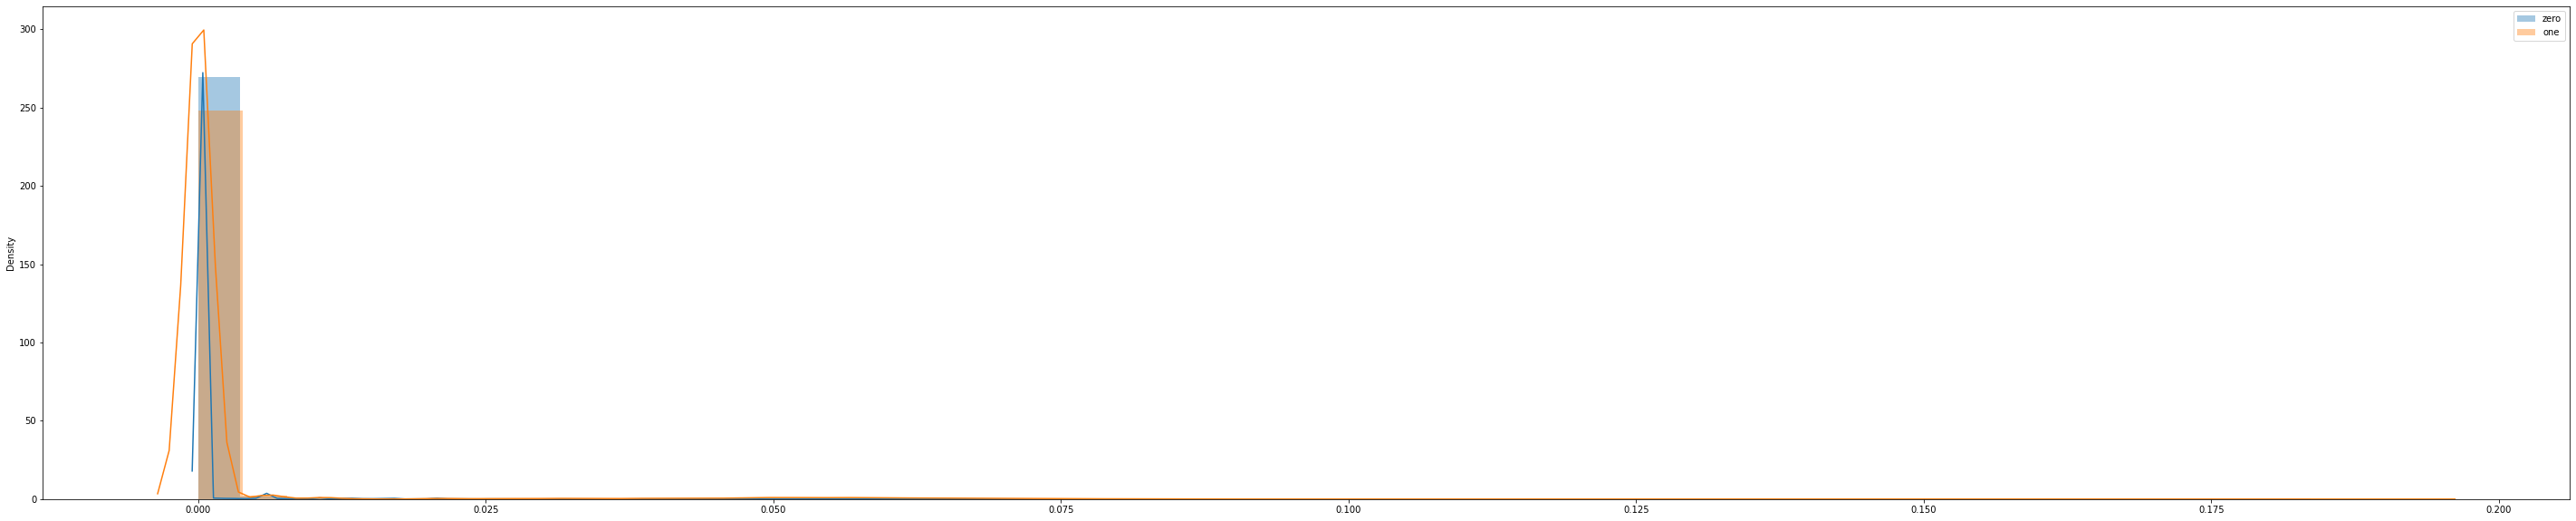

In [ ]:
plt.figure(figsize=(50, 10))
sns.distplot(zero, label='zero')
sns.distplot(one, label='one')
plt.legend()
plt.show()

In [ ]:
th = 1.291943e-05
def get_loss(x):
  global th 
  if x > th : 
    return 1
  else : 
    return 0
loss_df = pd.Series(total_loss)
loss_df2 = loss_df.apply(get_loss)

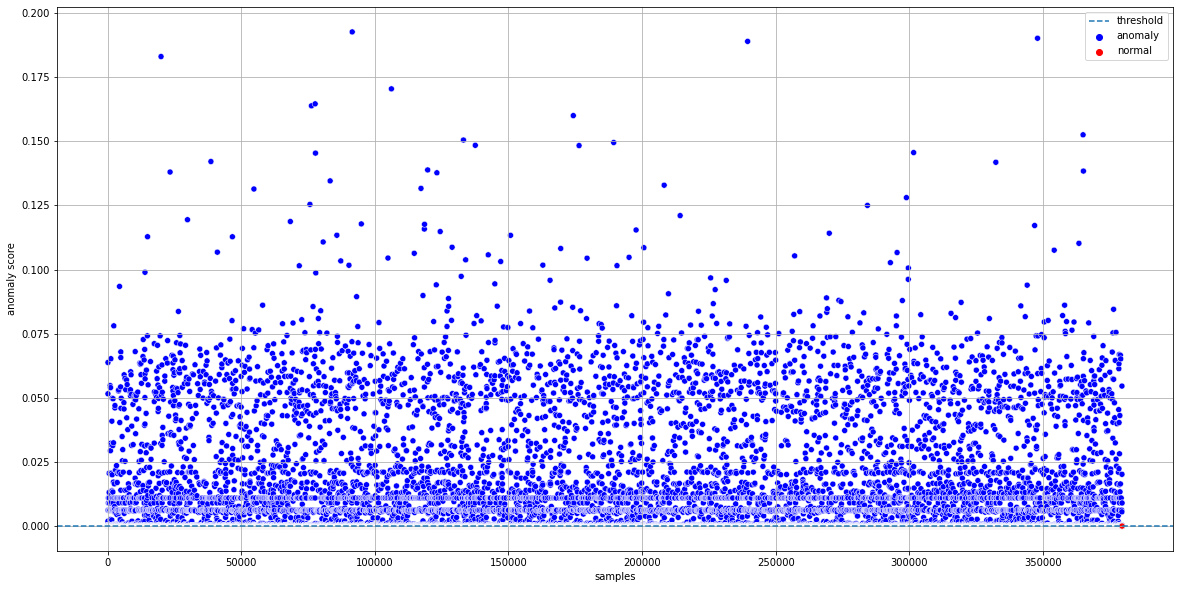

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(loss_df)), y= loss_df, hue=['normal' if i==0 else 'anomaly' for i in loss_df2],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = th, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

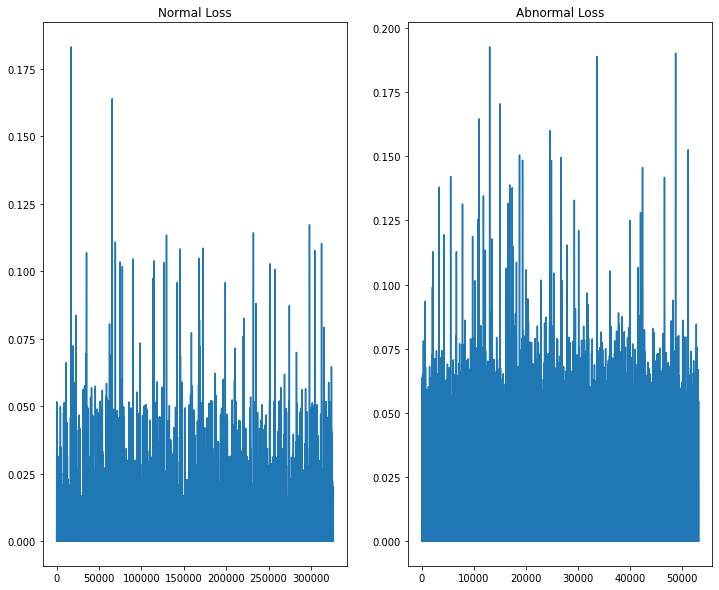

In [ ]:
zero_df = pd.DataFrame(zero)
one_df = pd.DataFrame(one)
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.plot(zero_df)
plt.title('Normal Loss')

plt.subplot(1,2,2)
plt.plot(one_df)
plt.title('Abnormal Loss')

plt.show()